In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[-0.7730]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[0.5748]], requires_grad=True)
alpha:  tensor([0.6926])
gt ols coef:  [[-0.77721226]]
gt ols intercept:  [0.59251046]
trunc ols coef:  [[-0.50018835]]
trunc ols intercept:  [1.0499281]


Text(0, 0.5, 'y')

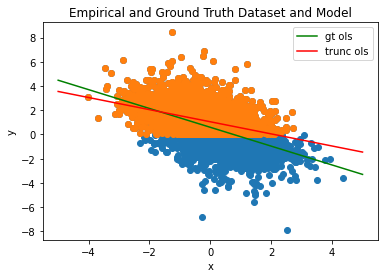

In [18]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + laplace.sample(ch.Size([X.size(0)]))
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [19]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.0143)
beta:  tensor(4.0143)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.6316])
trunc reg noise var:  tensor([2.0522])


Text(0, 0.5, 'y')

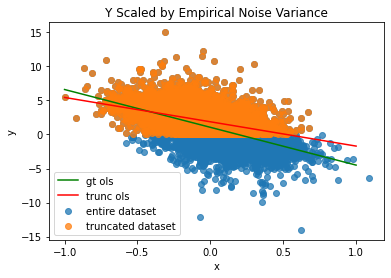

In [52]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)
emp_noise_scale = ch.sqrt(emp_noise_var/2) 

emp_stand_y_trunc = y_trunc / emp_noise_scale
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / emp_noise_scale

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([1.2631])
reg noise var:  tensor([2.0303])


Text(0, 0.5, 'y')

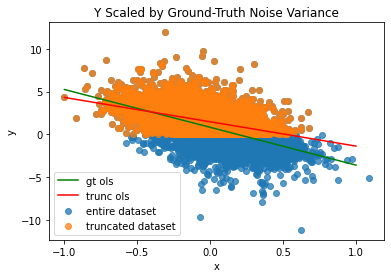

In [53]:
stand_noised, stand_y_trunc = noised / noise_scale, y_trunc / noise_scale

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [54]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * emp_noise_scale) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * emp_noise_scale)

0 steps | score: [0.08722872287034988]
100 steps | score: [-0.15371833741664886]
200 steps | score: [0.11577165126800537]
300 steps | score: [0.15002448856830597]
400 steps | score: [-0.040850937366485596]
500 steps | score: [0.04271867498755455]
600 steps | score: [0.01830844022333622]
700 steps | score: [0.04730379208922386]
800 steps | score: [-0.052826348692178726]
900 steps | score: [0.10823661088943481]
1000 steps | score: [0.08567563444375992]
1100 steps | score: [-0.0640784278512001]
1200 steps | score: [0.008505544625222683]


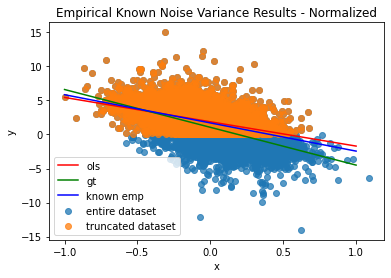

Text(0, 0.5, 'y')

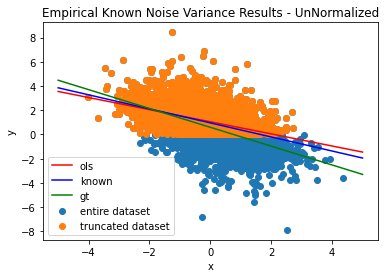

In [55]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [58]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=1, n=100, tol=1e-2, steps=2000)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * noise_scale) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * noise_scale

0 steps | score: [0.1404706835746765]
100 steps | score: [-0.20729883015155792]
200 steps | score: [-0.019203443080186844]
300 steps | score: [0.15922656655311584]
400 steps | score: [0.26590561866760254]
500 steps | score: [-0.19839715957641602]
600 steps | score: [-0.07279006391763687]
700 steps | score: [0.047994550317525864]
800 steps | score: [0.07560958713293076]
900 steps | score: [0.0676669031381607]
1000 steps | score: [-0.28352153301239014]
1100 steps | score: [0.052644044160842896]
1200 steps | score: [-0.017157278954982758]
1300 steps | score: [-0.22028736770153046]
1400 steps | score: [-0.1377340853214264]
1500 steps | score: [0.0061187297105789185]


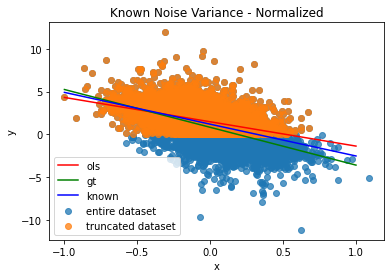

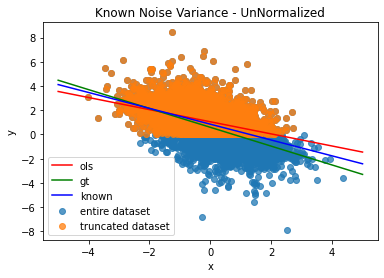

In [59]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [60]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=1, n=100, tol=5e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * emp_noise_scale) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * emp_noise_scale).detach().numpy()

0 steps | score: [0.2905574440956116, -0.20666351914405823]
100 steps | score: [-0.27120140194892883, -3.2981948852539062]
200 steps | score: [-1.2057424783706665, 2.8927805423736572]
300 steps | score: [-0.8965381383895874, 2.547687530517578]
400 steps | score: [-1.3437919616699219, 3.0747432708740234]
500 steps | score: [-0.338600754737854, 1.6003186702728271]
600 steps | score: [-0.18581794202327728, 1.1041582822799683]
700 steps | score: [-2.0519609451293945, 3.499739170074463]
800 steps | score: [-0.5100373029708862, 1.8548325300216675]
900 steps | score: [-0.8865644335746765, 2.509981870651245]
1000 steps | score: [-0.5900213122367859, 2.0247135162353516]
1100 steps | score: [0.15984177589416504, 0.3845093250274658]
1200 steps | score: [0.22827421128749847, 0.23511837422847748]
1300 steps | score: [-0.3410768210887909, 1.496913194656372]
1400 steps | score: [-0.5526643395423889, 1.8662344217300415]
1500 steps | score: [0.03078850731253624, 0.7469772100448608]
1600 steps | score: 

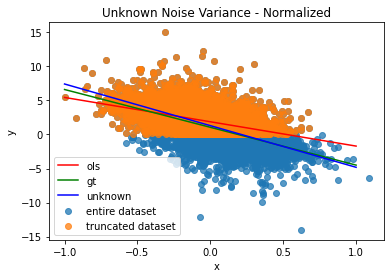

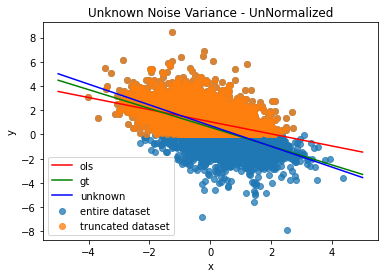

In [61]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [205]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('samples', 5000)

EXP = '5KLaplace'

In [ ]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 1, 1

# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)

C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0, -.75, -.5, -.25, 0.0]

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'c': float,
        'num_samples': int,
        'noise_scale': float, 
    })
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        noised = gt(X) + laplace.sample(ch.Size([X.size(0)]))
        
    for c in C: 
        phi = oracle.Left(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        val = int(.2*x_trunc.size(0))
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        print("gt params: ", gt_params)
        print("gt var: ", noise_var)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_noise_scale = ch.sqrt(emp_noise_var/2) 
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        trunc_reg = trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, bs=args.bs, n=100, tol=args.tol, steps=args.steps)
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
        w, w0 = (known_results.weight.detach().cpu() * ch.sqrt(noise_var)) / beta, known_results.bias.detach().cpu()[..., None] * ch.sqrt(noise_var)
        known_params = ch.cat([w, w0], dim=1).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # truncated regression with unknown variance
        # run procedure until get reasonable gradient value
        st = datetime.datetime.now()
        attempt, grad = 0, None
        best, unknown_results = None, None
        while (grad is None or grad < 3e-1) and attempt < 3:
            trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=True, bs=args.bs, n=100, tol=args.tol, steps=args.steps, val=val)
            res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
            grad = ch.abs(ch.cat([res.weight.grad.flatten(), res.bias.grad.flatten(), res.lambda_.grad.flatten()])).mean(0)
            if best is None or grad < best: 
                best, unknown_results = grad, res
            attempt += 1
    

        var_ = unknown_results.lambda_.inverse()
        unknown_var = var_ * emp_noise_var
        w, w0 = (((unknown_results.weight * var_) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_results.bias * var_ * ch.sqrt(emp_noise_var))).detach()
        unknown_params = ch.cat([w, w0], dim=1).flatten()
        print("unknown params: ", unknown_params)
        print("unknown variance: ", unknown_var)

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': ch.ones(1), 
            'c': c,
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/5KLaplace/b4bd8f1d-1c16-415e-973d-92ac979dc298
gt params:  tensor([-0.4374, -0.5629])
gt var:  tensor([1.])
0 steps | score: [0.10800917446613312]
100 steps | score: [0.0023618489503860474]
0 steps | score: [0.07307607680559158, 0.04460294172167778]
100 steps | score: [0.060631945729255676, 0.00428187008947134]
200 steps | score: [-0.006638931576162577, -0.030606089159846306]
300 steps | score: [0.07368598133325577, -0.0009927547071129084]
400 steps | score: [0.03048012964427471, -0.032228849828243256]
500 steps | score: [0.0568191222846508, 0.0187586210668087]
600 steps | score: [0.01627260632812977, -0.030605362728238106]
700 steps | score: [0.03499017655849457, -0.005631301552057266]
800 steps | score: [0.03305799141526222, 0.01631498895585537]
900 steps | score: [0.03034086711704731, 0.013808025047183037]
1000 steps | score: [0.048484548926353455, -0.006898004561662674]
1100 steps | score: [0.019857684150338173, -0.028092967346310616]
1

2200 steps | score: [-0.008176207542419434, -0.040064238011837006]
2300 steps | score: [0.003506687004119158, -0.04162737354636192]
2400 steps | score: [-0.020158570259809494, -0.02036542259156704]
2500 steps | score: [-0.0020073573105037212, -0.025771282613277435]
2600 steps | score: [-0.0073486631736159325, -0.029358666390180588]
2700 steps | score: [0.008042032830417156, -0.03985422104597092]
0 steps | score: [0.04814913496375084, 0.13163480162620544]
100 steps | score: [0.026316042989492416, 0.01410946249961853]
200 steps | score: [-0.01981344074010849, 0.03518388792872429]
300 steps | score: [0.02400747872889042, 0.008052496239542961]
400 steps | score: [-0.04720812663435936, 0.0773547813296318]
500 steps | score: [0.018751876428723335, 0.02832627296447754]
600 steps | score: [-0.013638179749250412, 0.03305227681994438]
700 steps | score: [0.029962101951241493, 0.0184052512049675]
800 steps | score: [-0.05135536193847656, 0.07503838837146759]
900 steps | score: [0.0184752307832241

500 steps | score: [0.005748148541897535, -0.016056548804044724]
600 steps | score: [-0.026025034487247467, 0.014619814231991768]
700 steps | score: [-0.05693848058581352, 0.06053105741739273]
800 steps | score: [0.023687738925218582, -0.011191222816705704]
900 steps | score: [0.006347586866468191, -0.022245561704039574]
1000 steps | score: [-0.022488728165626526, 0.04260466992855072]
1100 steps | score: [0.012871514074504375, 0.015349134802818298]
1200 steps | score: [0.021259775385260582, -0.02692963182926178]
1300 steps | score: [0.016095317900180817, -0.03234773129224777]
1400 steps | score: [-0.040882814675569534, 0.030013691633939743]
1500 steps | score: [0.018671609461307526, -0.005035941489040852]
1600 steps | score: [0.015580099076032639, -0.03363679349422455]
1700 steps | score: [-0.0021813372150063515, 0.007844413630664349]
0 steps | score: [0.1009615957736969, 0.12646767497062683]
100 steps | score: [0.05960189923644066, -0.0018642744980752468]
200 steps | score: [0.0110431

2400 steps | score: [-0.09386491030454636, 0.08384793996810913]
2500 steps | score: [-0.04861754551529884, 0.03321050480008125]
2600 steps | score: [-0.036427322775125504, 0.025137871503829956]
0 steps | score: [0.13387474417686462, 0.02625042200088501]
100 steps | score: [0.1355125904083252, -0.17346318066120148]
200 steps | score: [0.07569441944360733, -0.14089953899383545]
300 steps | score: [-0.07889747619628906, 0.06438849121332169]
400 steps | score: [0.09399338811635971, -0.15885807573795319]
500 steps | score: [0.07791326940059662, -0.16018088161945343]
600 steps | score: [-0.08292219787836075, 0.07442931085824966]
700 steps | score: [0.07894530892372131, -0.13217930495738983]
800 steps | score: [0.06593568623065948, -0.14374837279319763]
900 steps | score: [-0.08832760155200958, 0.07187943905591965]
1000 steps | score: [0.053396470844745636, -0.0961046814918518]
1100 steps | score: [0.056933656334877014, -0.1335637867450714]
1200 steps | score: [-0.07906730473041534, 0.0651946

2500 steps | score: [-0.03662975877523422, 0.04035717248916626]
2600 steps | score: [-0.010737303644418716, -0.0033096875995397568]
2700 steps | score: [-0.024548832327127457, 0.012561189010739326]
unknown params:  tensor([-0.5349, -1.0584])
unknown variance:  tensor([[1.2461]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4374, -0.5629])
gt var:  tensor([1.])
0 steps | score: [0.2799234390258789]
100 steps | score: [0.14207258820533752]
200 steps | score: [0.017057005316019058]
300 steps | score: [0.10568779706954956]
400 steps | score: [0.08192579448223114]
500 steps | score: [0.08118375390768051]
600 steps | score: [0.16840630769729614]
700 steps | score: [0.022722195833921432]
800 steps | score: [0.12728381156921387]
900 steps | score: [0.12014348804950714]
1000 steps | score: [0.061829522252082825]
1100 steps | score: [0.11143083870410919]
1200 steps | score: [0.07291217893362045]
1300 steps | score: [0.0729978084564209]
1400 steps | score: [0.10067496448755264]
1500 steps | sco

100 steps | score: [0.08125409483909607]
200 steps | score: [0.05458087474107742]
300 steps | score: [0.034909866750240326]
400 steps | score: [0.051588013768196106]
500 steps | score: [0.07414565235376358]
600 steps | score: [0.06067764759063721]
700 steps | score: [0.03996093571186066]
800 steps | score: [0.08332690596580505]
900 steps | score: [0.046340446919202805]
1000 steps | score: [0.056646183133125305]
1100 steps | score: [0.0584883838891983]
1200 steps | score: [0.06939209252595901]
1300 steps | score: [0.032997824251651764]
1400 steps | score: [0.0785936564207077]
1500 steps | score: [0.04321208596229553]
1600 steps | score: [0.04621436446905136]
1700 steps | score: [0.048020996153354645]
1800 steps | score: [0.06276429444551468]
1900 steps | score: [0.01072094589471817]
2000 steps | score: [0.05107581615447998]
2100 steps | score: [0.04808400571346283]
2200 steps | score: [0.0392538420855999]
2300 steps | score: [0.056227970868349075]
2400 steps | score: [0.0288482457399368

200 steps | score: [-0.021074026823043823, 0.012776762247085571]
300 steps | score: [0.029574427753686905, -0.028560690581798553]
400 steps | score: [0.08186457306146622, 0.0020208191126585007]
500 steps | score: [-0.008974355645477772, -0.03958665579557419]
600 steps | score: [0.04408886283636093, -0.021602429449558258]
700 steps | score: [0.005046686623245478, -0.06929760426282883]
800 steps | score: [0.06388121843338013, -0.04340746998786926]
900 steps | score: [0.014332312159240246, -0.035921111702919006]
1000 steps | score: [0.02444910630583763, -0.010088495910167694]
1100 steps | score: [0.011182236485183239, -0.016255035996437073]
1200 steps | score: [0.01592368446290493, -0.029161933809518814]
1300 steps | score: [0.06059366837143898, -0.008174222894012928]
1400 steps | score: [0.006291549187153578, -0.0267921332269907]
1500 steps | score: [0.02623584493994713, -0.009227970615029335]
1600 steps | score: [-0.004414016846567392, -0.03884739428758621]
1700 steps | score: [0.042358

1100 steps | score: [0.022931555286049843, 0.009307704865932465]
1200 steps | score: [-0.03537078574299812, 0.0032762917689979076]
1300 steps | score: [-0.04359161853790283, 0.03903575986623764]
1400 steps | score: [-0.03915487602353096, 0.02320544421672821]
1500 steps | score: [-0.006020339671522379, 0.012254946865141392]
1600 steps | score: [-0.012247135862708092, 0.00822019949555397]
1700 steps | score: [-0.029017312452197075, 0.02050386555492878]
1800 steps | score: [0.0018254596507176757, -0.008093475364148617]
0 steps | score: [0.09335518628358841, 0.08846491575241089]
100 steps | score: [0.054124146699905396, 0.021373432129621506]
200 steps | score: [-0.016682295128703117, -0.00482639204710722]
300 steps | score: [0.12443148344755173, -0.07596299797296524]
400 steps | score: [-0.007701450958848, -0.04550369083881378]
500 steps | score: [0.011399307288229465, 0.005887867882847786]
600 steps | score: [0.011091476306319237, -0.03953612968325615]
700 steps | score: [0.07394970208406

1000 steps | score: [0.04264606162905693, 0.02630797028541565]
1100 steps | score: [-0.007474638521671295, 0.09163299947977066]
1200 steps | score: [-0.04005550965666771, 0.106145940721035]
1300 steps | score: [0.0047035920433700085, 0.061447251588106155]
1400 steps | score: [0.02458760514855385, 0.05027679726481438]
1500 steps | score: [0.07616138458251953, -0.03141992539167404]
1600 steps | score: [0.0057790703140199184, 0.056659676134586334]
1700 steps | score: [-0.016934368759393692, 0.08094814419746399]
1800 steps | score: [0.020931288599967957, 0.03107673116028309]
1900 steps | score: [0.04878559336066246, 0.01329280436038971]
2000 steps | score: [0.0005034834030084312, 0.05683356523513794]
2100 steps | score: [-0.0013327546184882522, 0.06436735391616821]
2200 steps | score: [0.03073851391673088, 0.017424335703253746]
2300 steps | score: [0.028377806767821312, 0.03205536678433418]
2400 steps | score: [0.00017462203686591238, 0.06912195682525635]
2500 steps | score: [-0.0034627765

2300 steps | score: [0.0008957039681263268, -0.0029586274176836014]
0 steps | score: [0.06774666160345078, 0.12625399231910706]
100 steps | score: [-0.1100359559059143, 0.20183658599853516]
200 steps | score: [-0.0500609464943409, 0.01837770640850067]
300 steps | score: [-0.10374786704778671, 0.15518133342266083]
400 steps | score: [-0.09872203320264816, 0.11688216030597687]
500 steps | score: [-0.019401952624320984, -0.00018163397908210754]
600 steps | score: [-0.08609554916620255, 0.12359688431024551]
700 steps | score: [0.09722534567117691, -0.20044271647930145]
800 steps | score: [-0.03839152678847313, 0.05712125450372696]
900 steps | score: [-0.06732416152954102, 0.08547656238079071]
1000 steps | score: [-0.13097146153450012, 0.14975692331790924]
1100 steps | score: [-0.09082235395908356, 0.12388253211975098]
1200 steps | score: [-0.10229586809873581, 0.12911736965179443]
1300 steps | score: [-0.04759212210774422, 0.042587023228406906]
1400 steps | score: [-0.08844968676567078, 0.

300 steps | score: [-0.03250788897275925]
400 steps | score: [-0.026205265894532204]
500 steps | score: [-0.03202125057578087]
600 steps | score: [0.028890008106827736]
700 steps | score: [0.006942159030586481]
0 steps | score: [0.1965205818414688, -0.04317520931363106]
100 steps | score: [0.040697935968637466, 0.08518513292074203]
200 steps | score: [-0.07241956144571304, 0.22134141623973846]
300 steps | score: [-0.10684455186128616, 0.2548549771308899]
400 steps | score: [-0.12497606873512268, 0.2733173966407776]
500 steps | score: [-0.10535671561956406, 0.24705776572227478]
600 steps | score: [0.007809856440871954, 0.026866616681218147]
700 steps | score: [0.10593731701374054, -0.13365834951400757]
800 steps | score: [0.312423437833786, -0.6119058132171631]
900 steps | score: [-0.0280868299305439, 0.10428005456924438]
1000 steps | score: [-0.08573494851589203, 0.19421318173408508]
1100 steps | score: [0.07690942287445068, -0.09822279214859009]
1200 steps | score: [0.0307659674435853

300 steps | score: [0.051709163933992386, -0.007680105976760387]
400 steps | score: [-0.01311760675162077, 0.025646649301052094]
500 steps | score: [0.051300156861543655, -0.04021099582314491]
600 steps | score: [0.0412612222135067, -0.0162113755941391]
700 steps | score: [0.04568230360746384, -0.01305769570171833]
800 steps | score: [0.007520158309489489, 0.023475421592593193]
900 steps | score: [-0.0001829677348723635, -0.0038872379809617996]
0 steps | score: [0.03467293456196785, 0.015699071809649467]
100 steps | score: [0.06856177747249603, -0.02453337237238884]
200 steps | score: [-0.017819274216890335, 0.0067909350618720055]
300 steps | score: [0.020962249487638474, -0.03555295988917351]
400 steps | score: [-0.034561511129140854, -0.009440814144909382]
500 steps | score: [0.019377006217837334, -0.06945046782493591]
600 steps | score: [0.022650649771094322, -0.04406506568193436]
700 steps | score: [0.01510069239884615, -0.039415303617715836]
800 steps | score: [-0.0249976869672536

200 steps | score: [0.02833046205341816, -0.036410141736269]
300 steps | score: [-0.008113857358694077, -0.02132875844836235]
400 steps | score: [0.03191085159778595, -0.05478446185588837]
500 steps | score: [-0.027220262214541435, 0.01908205822110176]
600 steps | score: [-0.032986972481012344, 0.0019464027136564255]
700 steps | score: [0.045894213020801544, -0.06313373893499374]
800 steps | score: [-0.019829893484711647, -0.0041079409420490265]
900 steps | score: [0.047038715332746506, -0.06694676727056503]
1000 steps | score: [-0.014652424491941929, -0.004136070609092712]
1100 steps | score: [0.03141668438911438, -0.07521453499794006]
1200 steps | score: [-0.021222572773694992, 0.005314035341143608]
1300 steps | score: [0.003446022979915142, -0.022866174578666687]
1400 steps | score: [0.0189854484051466, -0.03973778337240219]
1500 steps | score: [0.002970602596178651, -0.03341418504714966]
1600 steps | score: [0.012892885133624077, -0.034785933792591095]
1700 steps | score: [0.010995

1600 steps | score: [-0.032202620059251785, 0.046829551458358765]
1700 steps | score: [-0.017497362568974495, 0.02625071443617344]
1800 steps | score: [0.004708229098469019, 0.006174844689667225]
0 steps | score: [0.1288031041622162, 0.08365621417760849]
100 steps | score: [-0.013139101676642895, 0.0866432785987854]
200 steps | score: [0.04647825285792351, -0.022749532014131546]
300 steps | score: [-0.055074840784072876, 0.10060956329107285]
400 steps | score: [0.026936454698443413, -0.0022534430027008057]
500 steps | score: [0.027530670166015625, -0.016670413315296173]
600 steps | score: [-0.02492767572402954, 0.04919370636343956]
700 steps | score: [0.07926052063703537, -0.09688179194927216]
800 steps | score: [0.0029798548202961683, 0.016496922820806503]
900 steps | score: [0.054318543523550034, -0.06421039998531342]
1000 steps | score: [0.008971595205366611, -0.004074178636074066]
0 steps | score: [0.1935597062110901, -0.012893849052488804]
100 steps | score: [0.02837494947016239, 

200 steps | score: [-0.08152363449335098]
300 steps | score: [-0.05699216201901436]
400 steps | score: [-0.01316830050200224]
500 steps | score: [-0.07868116348981857]
600 steps | score: [-0.051705408841371536]
700 steps | score: [0.00023100152611732483]
0 steps | score: [0.22753269970417023, -0.1700821816921234]
100 steps | score: [0.055873919278383255, -0.0027616024017333984]
200 steps | score: [-0.01724453829228878, 0.07724857330322266]
300 steps | score: [-0.021241597831249237, 0.05634414777159691]
400 steps | score: [0.1422797441482544, -0.24267832934856415]
500 steps | score: [-0.05777819827198982, 0.10617942363023758]
600 steps | score: [-0.06822613626718521, 0.11620982736349106]
700 steps | score: [-0.060141269117593765, 0.10424848645925522]
800 steps | score: [0.13005903363227844, -0.2332839071750641]
900 steps | score: [0.05200310796499252, -0.0981038510799408]
1000 steps | score: [0.06457936763763428, -0.12318377196788788]
1100 steps | score: [0.06315186619758606, -0.1246820

700 steps | score: [-0.0458771176636219, 0.04313155263662338]
800 steps | score: [-0.05871625989675522, -0.007171447388827801]
900 steps | score: [-0.021356509998440742, 0.026221491396427155]
1000 steps | score: [-0.00566124590113759, 0.04115990921854973]
1100 steps | score: [-0.01805683970451355, 0.05211959779262543]
1200 steps | score: [0.007173948921263218, 0.025462668389081955]
1300 steps | score: [-0.06849070638418198, 0.04185657203197479]
1400 steps | score: [0.015919789671897888, 0.04533044621348381]
1500 steps | score: [-0.008180489763617516, 0.05228329077363014]
1600 steps | score: [-0.011083617806434631, 0.04253336787223816]
1700 steps | score: [-0.02858782559633255, 0.016665585339069366]
1800 steps | score: [-0.02287411317229271, 0.029294835403561592]
1900 steps | score: [-0.004402266349643469, 0.03765547275543213]
2000 steps | score: [-0.024624258279800415, 0.03800171613693237]
2100 steps | score: [-0.0018970777746289968, 0.029443658888339996]
2200 steps | score: [-0.031616

2500 steps | score: [0.16282522678375244]
2600 steps | score: [0.14239782094955444]
0 steps | score: [0.049606144428253174, 0.09888823330402374]
100 steps | score: [-0.045643892139196396, 0.013046198524534702]
200 steps | score: [-0.06299702823162079, 0.02919882722198963]
300 steps | score: [-0.032347530126571655, -0.02485683374106884]
400 steps | score: [-0.001667770673520863, -0.028945717960596085]
500 steps | score: [-0.0006584334187209606, -0.003861796110868454]
0 steps | score: [0.1402694433927536, 0.040697600692510605]
100 steps | score: [0.04189411923289299, -0.038230858743190765]
200 steps | score: [0.011634640395641327, -0.020599322393536568]
300 steps | score: [0.044661059975624084, -0.07306914776563644]
400 steps | score: [0.06615716964006424, -0.06618625670671463]
500 steps | score: [0.06912264972925186, -0.055169157683849335]
600 steps | score: [0.01507471315562725, -0.01696920581161976]
700 steps | score: [-0.03135870397090912, -0.025659024715423584]
800 steps | score: [0

1900 steps | score: [-0.011899138800799847, 0.014639190398156643]
2000 steps | score: [-0.007702316157519817, 0.012507328763604164]
2100 steps | score: [-0.03733908757567406, 0.02401188760995865]
2200 steps | score: [-0.007063660770654678, 0.00552505673840642]
0 steps | score: [0.08592794835567474, 0.1189027726650238]
100 steps | score: [-0.062328848987817764, 0.06617002189159393]
200 steps | score: [-0.014813886024057865, 0.02116483263671398]
300 steps | score: [-0.07248825579881668, 0.031181700527668]
400 steps | score: [-0.04199923202395439, 0.07096977531909943]
500 steps | score: [0.011967102065682411, 0.03779572993516922]
600 steps | score: [0.025814151391386986, 0.005711645819246769]
700 steps | score: [-0.04031820595264435, 0.019492801278829575]
800 steps | score: [0.01586032100021839, -0.012164436280727386]
900 steps | score: [-0.034819647669792175, 0.046823978424072266]
1000 steps | score: [-0.03460719436407089, 0.009212382137775421]
1100 steps | score: [-0.01601564697921276, 

2500 steps | score: [-0.009385313838720322, -0.003997913561761379]
0 steps | score: [0.17583496868610382, -0.016208050772547722]
100 steps | score: [-0.01914992742240429, 0.052687570452690125]
200 steps | score: [0.1499350517988205, -0.1885535567998886]
300 steps | score: [0.03979576751589775, -0.0939721167087555]
400 steps | score: [-0.016636041924357414, 0.007319130934774876]
500 steps | score: [0.13469041883945465, -0.17811690270900726]
600 steps | score: [0.04337095841765404, -0.095956951379776]
700 steps | score: [-0.02356831729412079, 0.006198099814355373]
800 steps | score: [0.15331989526748657, -0.20494703948497772]
900 steps | score: [0.04404055327177048, -0.08686643838882446]
1000 steps | score: [-0.00972731877118349, -0.010650279000401497]
1100 steps | score: [0.12447957694530487, -0.17569652199745178]
1200 steps | score: [0.03828626126050949, -0.082710862159729]
1300 steps | score: [0.008061114698648453, -0.03632407262921333]
1400 steps | score: [0.0923551470041275, -0.1418

900 steps | score: [-0.0040986244566738605, 0.0803944543004036]
1000 steps | score: [0.09532396495342255, -0.06992156058549881]
1100 steps | score: [-0.0020999459084123373, 0.06426741927862167]
1200 steps | score: [0.031496841460466385, 0.02709590643644333]
1300 steps | score: [0.0961751714348793, -0.09402450174093246]
1400 steps | score: [0.003927231766283512, 0.059188634157180786]
1500 steps | score: [-0.04521006718277931, 0.12591709196567535]
1600 steps | score: [6.186225800774992e-05, 0.04954031854867935]
1700 steps | score: [0.019377296790480614, 0.03048771806061268]
1800 steps | score: [-0.023517681285738945, 0.0954340398311615]
1900 steps | score: [-0.04084400832653046, 0.11538030952215195]
2000 steps | score: [-0.005596507340669632, 0.06512275338172913]
2100 steps | score: [-0.004426354076713324, 0.0719756931066513]
2200 steps | score: [-0.017160965129733086, 0.09085610508918762]
2300 steps | score: [0.010876074433326721, 0.05196228623390198]
2400 steps | score: [0.029836952686

2400 steps | score: [-0.09686066955327988, 0.2187456488609314]
2500 steps | score: [-0.11440691351890564, 0.2577991485595703]
2600 steps | score: [-0.14010845124721527, 0.29905930161476135]
0 steps | score: [0.19586122035980225, -0.033470772206783295]
100 steps | score: [0.00955501664429903, 0.14825443923473358]
200 steps | score: [-0.12416093796491623, 0.29724591970443726]
300 steps | score: [-0.006666610017418861, 0.09086135029792786]
400 steps | score: [-0.05434948578476906, 0.15000909566879272]
500 steps | score: [-0.06972862780094147, 0.18739904463291168]
600 steps | score: [0.19120723009109497, -0.33961009979248047]
700 steps | score: [0.04338952526450157, -0.014905672520399094]
800 steps | score: [0.1711229532957077, -0.28209683299064636]
900 steps | score: [-0.038269005715847015, 0.12547066807746887]
1000 steps | score: [-0.05520106106996536, 0.14663833379745483]
1100 steps | score: [0.08120029419660568, -0.11768362671136856]
1200 steps | score: [-0.04124276712536812, 0.1203382

2600 steps | score: [-0.01057853177189827, 0.03926471248269081]
0 steps | score: [0.2322324514389038, -0.19605964422225952]
100 steps | score: [0.2868647575378418, -0.40227246284484863]
200 steps | score: [0.16193662583827972, -0.26058727502822876]
300 steps | score: [0.01754169352352619, 0.01667267084121704]
400 steps | score: [0.013904259540140629, -0.00438738614320755]
500 steps | score: [0.007911487482488155, 0.014656435698270798]
600 steps | score: [-0.031430017203092575, 0.06011293828487396]
700 steps | score: [0.398136168718338, -0.8781817555427551]
800 steps | score: [0.10215786099433899, -0.20657514035701752]
900 steps | score: [0.06802432984113693, -0.12834639847278595]
1000 steps | score: [0.03930144011974335, -0.07372952252626419]
1100 steps | score: [0.25132331252098083, -0.5674919486045837]
1200 steps | score: [0.09288300573825836, -0.1886957585811615]
1300 steps | score: [0.12020663172006607, -0.23982366919517517]
1400 steps | score: [-0.0091437678784132, 0.0168810375034

1100 steps | score: [0.025913622230291367, 0.010844973847270012]
1200 steps | score: [0.04212379455566406, -0.009872294962406158]
1300 steps | score: [0.05734247714281082, -0.016677962616086006]
1400 steps | score: [0.0723162442445755, -0.007664581760764122]
1500 steps | score: [0.04124806448817253, 0.008644785732030869]
1600 steps | score: [0.03638654574751854, 0.006011682562530041]
1700 steps | score: [0.05633530020713806, -0.021446354687213898]
1800 steps | score: [0.07603399455547333, -0.00963557418435812]
1900 steps | score: [0.041568823158741, 0.008285881951451302]
2000 steps | score: [0.04063994064927101, 0.005690061487257481]
2100 steps | score: [0.053257931023836136, -0.010945798829197884]
2200 steps | score: [0.061103545129299164, -0.008221752941608429]
2300 steps | score: [0.049423303455114365, 0.0013121897354722023]
2400 steps | score: [0.03770788758993149, 0.008543587289750576]
2500 steps | score: [0.04848811775445938, -0.01261947676539421]
2600 steps | score: [0.057117480

800 steps | score: [-0.019015351310372353, 0.01955457404255867]
900 steps | score: [-0.02837836742401123, 0.06163996458053589]
1000 steps | score: [-0.011873778887093067, -0.009910371154546738]
1100 steps | score: [-0.032112494111061096, -0.0025222646072506905]
1200 steps | score: [-0.04114477336406708, 0.03975622355937958]
1300 steps | score: [-0.004379589110612869, 0.010360096581280231]
1400 steps | score: [-0.022877318784594536, 0.016927845776081085]
1500 steps | score: [-0.01364226546138525, 0.0020613139495253563]
1600 steps | score: [-0.03190034255385399, 0.038374897092580795]
1700 steps | score: [0.00868982169777155, -0.010728335939347744]
1800 steps | score: [-0.02358490787446499, 0.001097375527024269]
1900 steps | score: [-0.033176131546497345, 0.02831191010773182]
2000 steps | score: [-0.026345882564783096, 0.0273030586540699]
2100 steps | score: [-0.0320114828646183, 0.0271003358066082]
2200 steps | score: [-0.005477010738104582, -0.003650757484138012]
0 steps | score: [0.061

400 steps | score: [-0.04808870702981949, 0.08323059976100922]
500 steps | score: [0.006975125055760145, 0.026289023458957672]
600 steps | score: [0.06362360715866089, -0.09626665711402893]
700 steps | score: [-0.07236633449792862, 0.09935548156499863]
800 steps | score: [0.01540621928870678, 0.013739394024014473]
900 steps | score: [0.04939575865864754, -0.07493646442890167]
1000 steps | score: [-0.04140602797269821, 0.059183236211538315]
1100 steps | score: [0.015330295078456402, 0.004372382536530495]
1200 steps | score: [0.07292136549949646, -0.10165739804506302]
1300 steps | score: [-0.05145227536559105, 0.07573491334915161]
1400 steps | score: [0.005695521831512451, 0.014718007296323776]
1500 steps | score: [0.025822008028626442, -0.03470122069120407]
1600 steps | score: [-0.0348307341337204, 0.061575643718242645]
1700 steps | score: [-0.011018458753824234, 0.03690680116415024]
1800 steps | score: [0.0047493199817836285, -0.006431978195905685]
0 steps | score: [0.09139198064804077

1900 steps | score: [0.044181011617183685, -0.09449870884418488]
2000 steps | score: [0.021780626848340034, -0.057696904987096786]
2100 steps | score: [0.021102361381053925, -0.04273376241326332]
2200 steps | score: [0.007810729555785656, -0.03018127754330635]
2300 steps | score: [0.013121132738888264, -0.03756598383188248]
2400 steps | score: [-0.0372837595641613, 0.037132199853658676]
2500 steps | score: [0.006877873558551073, -0.02415316551923752]
2600 steps | score: [-0.018542570993304253, 0.016346093267202377]
unknown params:  tensor([-0.4978, -0.9764])
unknown variance:  tensor([[1.3147]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4261, -0.5882])
gt var:  tensor([1.])
0 steps | score: [0.13820664584636688]
100 steps | score: [-0.056682370603084564]
200 steps | score: [-0.10624197125434875]
300 steps | score: [-0.20006681978702545]
400 steps | score: [-0.057970985770225525]
500 steps | score: [-0.07549836486577988]
600 steps | score: [-0.08874857425689697]
700 steps | score: 

300 steps | score: [0.058674849569797516]
400 steps | score: [-0.014379840344190598]
500 steps | score: [0.03743171691894531]
600 steps | score: [0.0923280343413353]
700 steps | score: [0.06837701797485352]
800 steps | score: [0.02378464862704277]
900 steps | score: [0.0407586470246315]
1000 steps | score: [0.08256611227989197]
1100 steps | score: [0.07946080714464188]
1200 steps | score: [0.023735977709293365]
1300 steps | score: [0.0468873530626297]
1400 steps | score: [0.06529675424098969]
1500 steps | score: [0.09961295127868652]
1600 steps | score: [0.028878405690193176]
1700 steps | score: [0.02835308015346527]
1800 steps | score: [0.08922900259494781]
1900 steps | score: [0.09144014865159988]
2000 steps | score: [0.03310871869325638]
2100 steps | score: [0.07389247417449951]
2200 steps | score: [0.05024112015962601]
2300 steps | score: [0.10243424773216248]
2400 steps | score: [0.06574036180973053]
2500 steps | score: [0.06344693899154663]
2600 steps | score: [0.0820118635892868

400 steps | score: [0.15040825307369232]
500 steps | score: [0.1036917120218277]
600 steps | score: [0.12306852638721466]
700 steps | score: [0.0012483298778533936]
0 steps | score: [0.13728629052639008, 0.08111906051635742]
100 steps | score: [0.1649342030286789, -0.20631222426891327]
200 steps | score: [0.1168191060423851, -0.11792449653148651]
300 steps | score: [-0.01933765970170498, 0.0589667409658432]
400 steps | score: [0.09853772819042206, -0.09799471497535706]
500 steps | score: [0.03723486140370369, -0.02424667775630951]
600 steps | score: [0.05616588890552521, -0.03378799185156822]
700 steps | score: [-0.009192327037453651, 0.03330394625663757]
800 steps | score: [0.08126216381788254, -0.07648958265781403]
900 steps | score: [0.1146727204322815, -0.11049214750528336]
1000 steps | score: [0.002604804001748562, 0.03909526765346527]
1100 steps | score: [0.059159211814403534, -0.045303333550691605]
1200 steps | score: [0.05158163234591484, -0.052031148225069046]
1300 steps | sco

1000 steps | score: [-0.07275299727916718, 0.07121704518795013]
1100 steps | score: [-0.0637843906879425, 0.042886145412921906]
1200 steps | score: [0.05434728041291237, -0.08463553339242935]
1300 steps | score: [-0.05064123496413231, 0.04550053924322128]
1400 steps | score: [0.05471082031726837, -0.10146266967058182]
1500 steps | score: [0.06776343286037445, -0.10746490210294724]
1600 steps | score: [-0.04417984560132027, 0.04305990785360336]
1700 steps | score: [-0.003635463770478964, -0.005436368752270937]
unknown params:  tensor([-0.4642, -0.7358])
unknown variance:  tensor([[1.0395]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4333, -0.5862])
gt var:  tensor([1.])
0 steps | score: [0.20380938053131104]
100 steps | score: [-0.037273939698934555]
200 steps | score: [0.04356137663125992]
300 steps | score: [-0.0862526223063469]
400 steps | score: [-0.027839265763759613]
500 steps | score: [0.024802669882774353]
600 steps | score: [-0.06098776310682297]
700 steps | score: [-0.0207

2300 steps | score: [0.032202139496803284, -0.048313338309526443]
2400 steps | score: [0.03596990182995796, -0.05585642531514168]
2500 steps | score: [0.016368739306926727, -0.019457833841443062]
2600 steps | score: [0.03739076107740402, -0.06431606411933899]
2700 steps | score: [0.022144587710499763, -0.034531425684690475]
0 steps | score: [0.08065130561590195, 0.13659349083900452]
100 steps | score: [-0.10338931530714035, 0.16974849998950958]
200 steps | score: [-0.1779731959104538, 0.2539801299571991]
300 steps | score: [-0.006001999601721764, 0.020862122997641563]
400 steps | score: [-0.08591187000274658, 0.08243104070425034]
500 steps | score: [-0.1438940167427063, 0.1948147863149643]
600 steps | score: [-0.005236743483692408, -0.004698185250163078]
0 steps | score: [0.17450134456157684, 0.019502243027091026]
100 steps | score: [-0.03541693463921547, 0.08054523169994354]
200 steps | score: [-0.09503421932458878, 0.14732736349105835]
300 steps | score: [0.06695330142974854, -0.0804

1900 steps | score: [-0.08016713708639145]
2000 steps | score: [-0.08717365562915802]
2100 steps | score: [-0.08365281671285629]
2200 steps | score: [-0.06808160245418549]
2300 steps | score: [-0.061160847544670105]
2400 steps | score: [-0.07876238226890564]
2500 steps | score: [-0.05926061421632767]
0 steps | score: [0.21113279461860657, -0.15905454754829407]
100 steps | score: [0.06375864893198013, -0.07477302104234695]
200 steps | score: [-0.025277266278862953, 0.05333439260721207]
300 steps | score: [0.3674220144748688, -0.8251473307609558]
400 steps | score: [0.24583588540554047, -0.5395205020904541]
500 steps | score: [-0.12108419835567474, 0.15428650379180908]
600 steps | score: [0.034405723214149475, -0.11335575580596924]
700 steps | score: [0.27698540687561035, -0.6083170771598816]
800 steps | score: [-0.10953117907047272, 0.1272895187139511]
900 steps | score: [0.1065988764166832, -0.2580426335334778]
1000 steps | score: [0.1374448984861374, -0.34179311990737915]
1100 steps |

500 steps | score: [0.057029418647289276]
600 steps | score: [0.12520083785057068]
700 steps | score: [0.07921984791755676]
800 steps | score: [0.052522219717502594]
900 steps | score: [0.14458471536636353]
1000 steps | score: [0.08418747037649155]
1100 steps | score: [0.09666040539741516]
1200 steps | score: [0.09001298993825912]
1300 steps | score: [0.0722803920507431]
1400 steps | score: [0.11259683966636658]
1500 steps | score: [0.10120467841625214]
1600 steps | score: [0.10046158730983734]
1700 steps | score: [0.09305234253406525]
1800 steps | score: [0.09710028767585754]
1900 steps | score: [0.0975317507982254]
2000 steps | score: [0.12135912477970123]
2100 steps | score: [0.13048169016838074]
2200 steps | score: [0.10768599063158035]
2300 steps | score: [0.09334376454353333]
2400 steps | score: [0.10695146024227142]
2500 steps | score: [0.07019725441932678]
2600 steps | score: [0.12788061797618866]
0 steps | score: [0.003248180029913783, 0.03774670138955116]
100 steps | score: [

1200 steps | score: [0.020192507654428482, -0.06398753821849823]
1300 steps | score: [0.006586027331650257, -0.060449808835983276]
1400 steps | score: [0.015486903488636017, -0.05665053427219391]
1500 steps | score: [0.07788466662168503, -0.09728202223777771]
1600 steps | score: [0.030507458373904228, -0.06700382381677628]
1700 steps | score: [0.005247316788882017, -0.06131373345851898]
1800 steps | score: [0.013928613625466824, -0.058060422539711]
1900 steps | score: [0.06203743442893028, -0.08697368204593658]
2000 steps | score: [0.0361490398645401, -0.06860685348510742]
2100 steps | score: [0.01589396595954895, -0.05719420686364174]
2200 steps | score: [0.01679336093366146, -0.060550302267074585]
2300 steps | score: [0.05159313976764679, -0.0764041319489479]
2400 steps | score: [0.0339282788336277, -0.06903054565191269]
2500 steps | score: [0.024781618267297745, -0.06708454340696335]
2600 steps | score: [0.014834616333246231, -0.05839980021119118]
2700 steps | score: [0.039019919931

100 steps | score: [-0.05042558163404465, 0.08436741679906845]
200 steps | score: [-0.06391123682260513, 0.02675621211528778]
300 steps | score: [0.0009650519350543618, -0.05140933394432068]
400 steps | score: [-0.0575576014816761, 0.026387805119156837]
500 steps | score: [-0.05246979370713234, -0.0018803086131811142]
600 steps | score: [-0.017357148230075836, -0.029904937371611595]
700 steps | score: [-0.09261006116867065, 0.02963264286518097]
800 steps | score: [-0.05379897728562355, 0.0544256791472435]
900 steps | score: [-0.05789262428879738, 0.025663908571004868]
1000 steps | score: [-0.014111526310443878, -0.03522072732448578]
1100 steps | score: [-0.057440195232629776, 0.01533803902566433]
1200 steps | score: [-0.040148358792066574, -0.003828282468020916]
1300 steps | score: [-0.024787109345197678, -0.019005613401532173]
1400 steps | score: [-0.06053305044770241, 0.009302601218223572]
1500 steps | score: [-0.0644778162240982, 0.046549778431653976]
1600 steps | score: [-0.0474825

200 steps | score: [0.22990119457244873, -0.295058012008667]
300 steps | score: [-0.022035963833332062, 0.03616567701101303]
400 steps | score: [-0.049672625958919525, 0.08700748533010483]
500 steps | score: [0.037459276616573334, -0.020741363987326622]
600 steps | score: [0.04611503705382347, -0.06982869654893875]
700 steps | score: [0.06776197999715805, -0.07946120947599411]
800 steps | score: [-0.003638165770098567, 0.014836421236395836]
900 steps | score: [0.057468511164188385, -0.08477085083723068]
1000 steps | score: [0.16198419034481049, -0.2407245635986328]
1100 steps | score: [0.02790149487555027, -0.03200012072920799]
1200 steps | score: [0.04682724550366402, -0.06654033809900284]
1300 steps | score: [0.0563177615404129, -0.05192343518137932]
1400 steps | score: [-0.0016368119977414608, 0.011356319300830364]
1500 steps | score: [0.04902535304427147, -0.06440133601427078]
1600 steps | score: [0.024766800925135612, -0.031217027455568314]
1700 steps | score: [0.03339705616235733

100 steps | score: [0.012494928203523159, 0.09836271405220032]
200 steps | score: [-0.06300190836191177, 0.17424558103084564]
300 steps | score: [0.07367775589227676, -0.11390388011932373]
400 steps | score: [-0.05598803237080574, 0.13975241780281067]
500 steps | score: [-0.03611830621957779, 0.07630190253257751]
600 steps | score: [0.2512679398059845, -0.47413963079452515]
700 steps | score: [0.1611979454755783, -0.31042614579200745]
800 steps | score: [0.049631714820861816, -0.05846976861357689]
900 steps | score: [-0.041073430329561234, 0.09055003523826599]
1000 steps | score: [0.10183176398277283, -0.1708257496356964]
1100 steps | score: [0.018499238416552544, -0.017298556864261627]
1200 steps | score: [0.07050590962171555, -0.11285124719142914]
1300 steps | score: [0.05353672057390213, -0.08959249407052994]
1400 steps | score: [0.06247490271925926, -0.10514966398477554]
1500 steps | score: [0.03894215077161789, -0.05998733267188072]
1600 steps | score: [0.045690007507801056, -0.07

2100 steps | score: [0.045073483139276505, -0.003976363223046064]
2200 steps | score: [0.015109801664948463, 0.022203773260116577]
2300 steps | score: [0.03705662488937378, 0.0006234063766896725]
2400 steps | score: [0.04080913960933685, -0.007074699271470308]
2500 steps | score: [0.03885635361075401, 8.669169619679451e-05]
2600 steps | score: [0.024572422727942467, 0.011701452545821667]
2700 steps | score: [0.03256024420261383, 0.009930175729095936]
0 steps | score: [0.08413027971982956, 0.07539710402488708]
100 steps | score: [0.029538927599787712, 0.020050061866641045]
200 steps | score: [-0.03200410678982735, 0.04570920765399933]
300 steps | score: [0.03933366388082504, -0.035398930311203]
400 steps | score: [0.01740529201924801, -0.004097044933587313]
500 steps | score: [0.05764779448509216, 0.00036424025893211365]
600 steps | score: [-0.016717977821826935, 0.04890593886375427]
700 steps | score: [-0.0004392928385641426, -0.015067140571773052]
800 steps | score: [0.012696972116827

1900 steps | score: [0.027884332463145256, 0.001443503424525261]
2000 steps | score: [0.012149295769631863, 0.02351580560207367]
2100 steps | score: [-0.003052172949537635, 0.04246023669838905]
2200 steps | score: [0.011508692055940628, 0.019070494920015335]
2300 steps | score: [0.010734640061855316, 0.03312411904335022]
2400 steps | score: [-0.007784366607666016, 0.03879360482096672]
2500 steps | score: [-0.00489111477509141, 0.030677806586027145]
2600 steps | score: [-0.006222685799002647, 0.033553820103406906]
unknown params:  tensor([-0.4109, -0.5357])
unknown variance:  tensor([[0.8782]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4366, -0.5961])
gt var:  tensor([1.])
0 steps | score: [0.17676515877246857]
100 steps | score: [0.10760239511728287]
200 steps | score: [0.04717165231704712]
300 steps | score: [0.07278133928775787]
400 steps | score: [-0.012238516472280025]
500 steps | score: [-0.006155752576887608]
0 steps | score: [0.06922014057636261, 0.11152024567127228]
100 st

900 steps | score: [0.07985144108533859, -0.10676176100969315]
1000 steps | score: [-0.11454945057630539, 0.18358372151851654]
1100 steps | score: [-0.03637810796499252, 0.07811419665813446]
1200 steps | score: [0.017335867509245872, -0.003023136407136917]
1300 steps | score: [-0.09005215018987656, 0.1522548347711563]
1400 steps | score: [-0.016256706789135933, 0.053678546100854874]
1500 steps | score: [-0.004655699245631695, 0.03734694421291351]
1600 steps | score: [-0.07170532643795013, 0.12699562311172485]
1700 steps | score: [-0.025567427277565002, 0.07323238253593445]
1800 steps | score: [-0.03648703545331955, 0.08029690384864807]
1900 steps | score: [-0.0723244771361351, 0.1312071979045868]
2000 steps | score: [-0.052638158202171326, 0.10557898879051208]
2100 steps | score: [-0.06047944352030754, 0.1027190238237381]
2200 steps | score: [-0.07810341566801071, 0.14222948253154755]
2300 steps | score: [-0.023175908252596855, 0.060649048537015915]
2400 steps | score: [-0.037282105535

2600 steps | score: [0.0001240700512425974, 0.04681994765996933]
0 steps | score: [0.1050134226679802, 0.1260707676410675]
100 steps | score: [0.12257955223321915, -0.07741345465183258]
200 steps | score: [-0.005941728595644236, 0.05026073008775711]
300 steps | score: [-0.1499268263578415, 0.23442822694778442]
400 steps | score: [-0.14453889429569244, 0.22835013270378113]
500 steps | score: [0.03915076330304146, -0.05432339757680893]
600 steps | score: [-0.10899271816015244, 0.18344545364379883]
700 steps | score: [0.08010919392108917, -0.08211401104927063]
800 steps | score: [-0.034770410507917404, 0.04860936850309372]
900 steps | score: [-0.03434997797012329, 0.06612060964107513]
1000 steps | score: [0.016360310837626457, -0.01855623908340931]
1100 steps | score: [-0.1009233370423317, 0.15727265179157257]
1200 steps | score: [-0.12708590924739838, 0.20009243488311768]
1300 steps | score: [0.06734103709459305, -0.09722606092691422]
1400 steps | score: [-0.056637778878211975, 0.1104680

1900 steps | score: [-0.05538731440901756, 0.04949861019849777]
2000 steps | score: [-0.14332035183906555, 0.20876950025558472]
2100 steps | score: [-0.07280434668064117, 0.0882178246974945]
2200 steps | score: [-0.1374627649784088, 0.2081357091665268]
2300 steps | score: [-0.014441343955695629, -0.03549235314130783]
2400 steps | score: [-0.057027142494916916, 0.06128118559718132]
2500 steps | score: [-0.05069093406200409, 0.0431208573281765]
0 steps | score: [0.17762379348278046, -0.07295552641153336]
100 steps | score: [0.02614550106227398, 0.07678281515836716]
200 steps | score: [-0.1268525868654251, 0.24997064471244812]
300 steps | score: [-0.13074339926242828, 0.26246365904808044]
400 steps | score: [0.089821457862854, -0.1790822446346283]
500 steps | score: [0.06251450628042221, -0.09232774376869202]
600 steps | score: [0.009786629118025303, -0.029449742287397385]
700 steps | score: [-0.08615531027317047, 0.15113890171051025]
800 steps | score: [0.12668325006961823, -0.2389374971

1000 steps | score: [-0.05016476288437843, -0.011560231447219849]
1100 steps | score: [-0.0006617208709940314, -0.027990024536848068]
1200 steps | score: [0.002132836962118745, -0.014503407292068005]
1300 steps | score: [-0.008356953971087933, -0.03831075131893158]
1400 steps | score: [-0.008739221841096878, -0.022694258019328117]
1500 steps | score: [-0.009555770084261894, -0.015692971646785736]
1600 steps | score: [0.015608824789524078, -0.05385180562734604]
1700 steps | score: [0.011087176389992237, -0.029283540323376656]
1800 steps | score: [0.01744765043258667, -0.04047428071498871]
1900 steps | score: [-0.019453879445791245, -0.018550554290413857]
2000 steps | score: [-0.004199082963168621, -0.03418755531311035]
2100 steps | score: [0.0004223271971568465, -0.029430698603391647]
2200 steps | score: [0.0062621161341667175, -0.03455735370516777]
2300 steps | score: [-0.0024482684675604105, -0.03382205590605736]
2400 steps | score: [-0.0041128285229206085, -0.025574106723070145]
2500

100 steps | score: [-0.00881959218531847, 0.06604238599538803]
200 steps | score: [0.03284769132733345, -0.08588039129972458]
300 steps | score: [0.023135768249630928, -0.007349040359258652]
400 steps | score: [0.017289582639932632, -0.007870513945817947]
500 steps | score: [0.007683760952204466, -0.0015702913515269756]
unknown params:  tensor([-0.3992, -0.5276])
unknown variance:  tensor([[0.8419]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4215, -0.6020])
gt var:  tensor([1.])
0 steps | score: [0.1687626838684082]
100 steps | score: [0.020811455324292183]
200 steps | score: [0.08529302477836609]
300 steps | score: [-0.008695576339960098]
0 steps | score: [0.12034556269645691, 0.12762534618377686]
100 steps | score: [0.04875187948346138, 0.06617050617933273]
200 steps | score: [0.10700459778308868, -0.078235924243927]
300 steps | score: [-0.017056167125701904, 0.04129953682422638]
400 steps | score: [-0.028004810214042664, 0.0635436475276947]
500 steps | score: [0.069757029414176

0 steps | score: [0.16578319668769836, 0.0966654121875763]
100 steps | score: [0.007583831436932087, 0.0780768021941185]
200 steps | score: [-0.050366733223199844, 0.1092405915260315]
300 steps | score: [0.022855184972286224, 0.04690764099359512]
400 steps | score: [-0.01954706385731697, 0.08369100093841553]
500 steps | score: [-0.07131633907556534, 0.11952900886535645]
600 steps | score: [0.12794744968414307, -0.11027568578720093]
700 steps | score: [0.002939315512776375, 0.04947412759065628]
800 steps | score: [0.0025940362829715014, 0.03102927654981613]
900 steps | score: [0.03598109260201454, 0.00845343992114067]
1000 steps | score: [0.023709295317530632, 0.029123947024345398]
1100 steps | score: [0.0022204311098903418, 0.03164888173341751]
1200 steps | score: [0.07670649141073227, -0.04532996192574501]
1300 steps | score: [0.029194938018918037, 0.013775115832686424]
1400 steps | score: [0.003523959079757333, 0.04453510418534279]
1500 steps | score: [0.0475928820669651, -0.01089063

900 steps | score: [-0.051958899945020676, 0.12140967696905136]
1000 steps | score: [-0.04430239647626877, 0.11793255060911179]
1100 steps | score: [0.09869559109210968, -0.13673466444015503]
1200 steps | score: [0.11914359778165817, -0.16879208385944366]
1300 steps | score: [0.05259706825017929, -0.03474852070212364]
1400 steps | score: [0.03714527189731598, -0.026482854038476944]
1500 steps | score: [-0.052077848464250565, 0.11382053047418594]
1600 steps | score: [0.08140195161104202, -0.09839442372322083]
1700 steps | score: [0.03238483518362045, -0.015295642428100109]
1800 steps | score: [0.07120494544506073, -0.09146884828805923]
1900 steps | score: [0.024467501789331436, 0.0006157699972391129]
2000 steps | score: [-0.03402215614914894, 0.0916321724653244]
2100 steps | score: [0.009104189462959766, 0.019205501303076744]
2200 steps | score: [0.050881341099739075, -0.056637197732925415]
2300 steps | score: [0.04467592015862465, -0.03742583841085434]
2400 steps | score: [0.0247985124

400 steps | score: [0.005395180080085993, 0.018381774425506592]
500 steps | score: [0.14161646366119385, -0.2120083123445511]
600 steps | score: [-0.11905352771282196, 0.25307318568229675]
700 steps | score: [-0.16461890935897827, 0.32106539607048035]
800 steps | score: [-0.11610463261604309, 0.23074470460414886]
900 steps | score: [-0.14180852472782135, 0.2878701388835907]
1000 steps | score: [-0.12769213318824768, 0.25015363097190857]
1100 steps | score: [-0.16093996167182922, 0.32343024015426636]
1200 steps | score: [0.12651404738426208, -0.21665936708450317]
1300 steps | score: [0.13328233361244202, -0.2304362803697586]
1400 steps | score: [0.11598857492208481, -0.22273103892803192]
1500 steps | score: [0.0008595088729634881, 0.011010538786649704]
1600 steps | score: [0.007579599507153034, 0.01823548972606659]
1700 steps | score: [-0.03683508560061455, 0.08419710397720337]
1800 steps | score: [-0.024532608687877655, 0.07955101132392883]
1900 steps | score: [-0.00952267274260521, 0.

1900 steps | score: [-0.03715256229043007, 0.034041181206703186]
2000 steps | score: [-0.026958005502820015, 0.03800405189394951]
2100 steps | score: [-0.004741930868476629, 0.010797487571835518]
2200 steps | score: [-0.024657465517520905, 0.0028387221973389387]
2300 steps | score: [-0.02076558768749237, 0.020030131563544273]
2400 steps | score: [-0.03018934465944767, 0.027123473584651947]
2500 steps | score: [-0.023313358426094055, 0.012778856791555882]
2600 steps | score: [-0.02610792964696884, 0.014669486321508884]
0 steps | score: [0.08762393146753311, 0.030915187671780586]
100 steps | score: [0.011193154379725456, -0.026199547573924065]
200 steps | score: [0.08233436197042465, -0.004013156518340111]
300 steps | score: [0.08928339928388596, -0.05892711132764816]
400 steps | score: [0.0697660744190216, -0.07491926848888397]
500 steps | score: [0.02491196244955063, 0.02454330213367939]
600 steps | score: [0.03979276493191719, 0.008703447878360748]
700 steps | score: [0.05176059529185

1200 steps | score: [0.004416991490870714, 0.006525006145238876]
unknown params:  tensor([-0.4405, -0.5504])
unknown variance:  tensor([[0.9435]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4319, -0.5835])
gt var:  tensor([1.])
0 steps | score: [0.3946269452571869]
100 steps | score: [0.29662466049194336]
200 steps | score: [0.34105104207992554]
300 steps | score: [0.32095444202423096]
400 steps | score: [0.298074334859848]
500 steps | score: [0.24700216948986053]
600 steps | score: [0.3304295837879181]
700 steps | score: [0.2706986367702484]
800 steps | score: [0.22773821651935577]
900 steps | score: [0.29586949944496155]
1000 steps | score: [0.27484744787216187]
1100 steps | score: [0.2657497823238373]
1200 steps | score: [0.25726261734962463]
1300 steps | score: [0.25668269395828247]
1400 steps | score: [0.24921981990337372]
1500 steps | score: [0.2360110580921173]
1600 steps | score: [0.30249908566474915]
1700 steps | score: [0.26341429352760315]
1800 steps | score: [0.27096831

1900 steps | score: [0.04742085933685303, -0.047868020832538605]
2000 steps | score: [0.029574183747172356, -0.01855643279850483]
2100 steps | score: [0.029533086344599724, -0.018605098128318787]
2200 steps | score: [0.06505218148231506, -0.0725456029176712]
2300 steps | score: [0.04088667035102844, -0.02968638204038143]
2400 steps | score: [0.028286265209317207, -0.013826195150613785]
2500 steps | score: [0.06995115429162979, -0.06256338208913803]
0 steps | score: [0.11036107689142227, 0.09303370118141174]
100 steps | score: [0.01418701559305191, 0.003675815649330616]
200 steps | score: [-0.026940496638417244, -0.011324782855808735]
300 steps | score: [0.04648392274975777, -0.04623020067811012]
400 steps | score: [-0.007065889425575733, -0.0032057813368737698]
0 steps | score: [0.13276568055152893, 0.05142392963171005]
100 steps | score: [0.05532994121313095, -0.04805789142847061]
200 steps | score: [-0.00530073931440711, -0.038050390779972076]
300 steps | score: [0.09517855197191238,

300 steps | score: [-0.06639350205659866, 0.09904571622610092]
400 steps | score: [-0.025038819760084152, 0.04927723482251167]
500 steps | score: [-0.09764853119850159, 0.11833970248699188]
600 steps | score: [0.03224571794271469, -0.03876370191574097]
700 steps | score: [0.34592828154563904, -0.6241486072540283]
800 steps | score: [0.02003379724919796, -0.05067029595375061]
900 steps | score: [-0.01884455606341362, 0.022021666169166565]
1000 steps | score: [0.05120355263352394, -0.08766764402389526]
1100 steps | score: [-0.041974931955337524, 0.04762786999344826]
1200 steps | score: [-0.015346847474575043, 0.014051975682377815]
1300 steps | score: [0.04474949091672897, -0.08669570088386536]
1400 steps | score: [0.005391543265432119, -0.007071522530168295]
unknown params:  tensor([-0.4940, -0.8855])
unknown variance:  tensor([[1.1012]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4319, -0.5835])
gt var:  tensor([1.])
0 steps | score: [0.32654687762260437]
100 steps | score: [0.05166

600 steps | score: [-0.027581248432397842, 0.09084033966064453]
700 steps | score: [-0.06867330521345139, 0.17799462378025055]
800 steps | score: [0.11393044143915176, -0.18075068295001984]
900 steps | score: [-0.06409747153520584, 0.1658330112695694]
1000 steps | score: [0.02096722088754177, -0.009151659905910492]
1100 steps | score: [-0.07759113609790802, 0.19039388000965118]
1200 steps | score: [0.11011718958616257, -0.1732873022556305]
1300 steps | score: [-0.048616088926792145, 0.1372506320476532]
1400 steps | score: [-0.010956046171486378, 0.05989310145378113]
1500 steps | score: [-0.1110031008720398, 0.23565717041492462]
1600 steps | score: [0.047031376510858536, -0.05011942982673645]
1700 steps | score: [-0.0517609529197216, 0.129909485578537]
1800 steps | score: [-0.05608860403299332, 0.1445281207561493]
1900 steps | score: [0.011232905089855194, 0.012630976736545563]
2000 steps | score: [-0.09348977357149124, 0.2024742215871811]
2100 steps | score: [-0.050458360463380814, 0.1

1400 steps | score: [0.3277546763420105]
1500 steps | score: [0.2553238868713379]
1600 steps | score: [0.19675084948539734]
1700 steps | score: [0.25681790709495544]
1800 steps | score: [0.2976582944393158]
1900 steps | score: [0.24463418126106262]
2000 steps | score: [0.19993223249912262]
2100 steps | score: [0.25072771310806274]
2200 steps | score: [0.282072514295578]
2300 steps | score: [0.25290611386299133]
2400 steps | score: [0.23537373542785645]
2500 steps | score: [0.2795352637767792]
2600 steps | score: [0.28804999589920044]
2700 steps | score: [0.27304351329803467]
2800 steps | score: [0.22393128275871277]
0 steps | score: [0.04148073121905327, 0.11340247839689255]
100 steps | score: [-0.06905005127191544, 0.08057348430156708]
200 steps | score: [-0.009155676700174809, 0.039906665682792664]
300 steps | score: [-0.02492695488035679, 0.06588893383741379]
400 steps | score: [-0.019971096888184547, 0.012091415002942085]
500 steps | score: [-0.048880573362112045, 0.040726345032453

800 steps | score: [-0.019369708374142647, -0.047810669988393784]
900 steps | score: [0.03749963268637657, -0.03169121593236923]
1000 steps | score: [-0.07409954816102982, 0.05115345120429993]
1100 steps | score: [-0.057488735765218735, 0.028043895959854126]
1200 steps | score: [0.0039079682901501656, -0.03881886973977089]
1300 steps | score: [0.016580253839492798, -0.019841859117150307]
1400 steps | score: [-0.05454538017511368, 0.038903817534446716]
1500 steps | score: [-0.06419108808040619, 0.031590983271598816]
1600 steps | score: [-0.049379751086235046, 0.009258550591766834]
1700 steps | score: [-0.01212642714381218, -0.002508364850655198]
1800 steps | score: [-0.03867862746119499, 0.025120848789811134]
1900 steps | score: [-0.007390779908746481, -0.021146509796380997]
2000 steps | score: [-0.03685417026281357, 0.007734963670372963]
2100 steps | score: [-0.006523124407976866, -0.013866808265447617]
2200 steps | score: [-0.04629260301589966, 0.029734227806329727]
2300 steps | score

unknown params:  tensor([-0.4241, -0.5772])
unknown variance:  tensor([[1.0031]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4302, -0.5904])
gt var:  tensor([1.])
0 steps | score: [0.1209200918674469]
100 steps | score: [0.016733959317207336]
200 steps | score: [-0.09585549682378769]
300 steps | score: [-0.025605978444218636]
400 steps | score: [-0.06555002927780151]
500 steps | score: [-0.037929680198431015]
600 steps | score: [-0.043779924511909485]
700 steps | score: [0.002136274240911007]
0 steps | score: [0.01149249728769064, 0.23845326900482178]
100 steps | score: [0.001198005280457437, 0.08516206592321396]
200 steps | score: [-0.18454767763614655, 0.22301289439201355]
300 steps | score: [-0.1291874200105667, 0.20471617579460144]
400 steps | score: [-0.17115408182144165, 0.21925869584083557]
500 steps | score: [-0.1166742593050003, 0.18074776232242584]
600 steps | score: [-0.10274876654148102, 0.15862363576889038]
700 steps | score: [-0.007677855435758829, 0.01662983186542987

1900 steps | score: [-0.0008506796439178288, -0.03141068294644356]
2000 steps | score: [-0.013142641633749008, -0.02629166655242443]
2100 steps | score: [-0.02778870239853859, -0.006219089031219482]
2200 steps | score: [-0.0024815304204821587, -0.048700492829084396]
2300 steps | score: [-0.011072426103055477, -0.0333016999065876]
2400 steps | score: [-0.027048837393522263, -0.01477230153977871]
2500 steps | score: [-0.00571246724575758, -0.03805665671825409]
2600 steps | score: [0.003639577655121684, -0.04948326200246811]
2700 steps | score: [-0.019447317346930504, -0.014874681830406189]
0 steps | score: [0.14094385504722595, 0.12572790682315826]
100 steps | score: [0.23828403651714325, -0.2712630033493042]
200 steps | score: [-0.0865500196814537, 0.17746245861053467]
300 steps | score: [0.001513441908173263, 0.08650805056095123]
400 steps | score: [0.047210607677698135, -0.01301121711730957]
500 steps | score: [-0.05044793710112572, 0.13344977796077728]
600 steps | score: [-0.01999742

2300 steps | score: [-0.05536043271422386, 0.12455269694328308]
2400 steps | score: [-0.0733160525560379, 0.1415165662765503]
2500 steps | score: [-0.061875395476818085, 0.1289292573928833]
2600 steps | score: [-0.05286424979567528, 0.11480656266212463]
2700 steps | score: [-0.09970320761203766, 0.18034584820270538]
unknown params:  tensor([-0.5029, -1.0021])
unknown variance:  tensor([[1.2214]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4302, -0.5904])
gt var:  tensor([1.])
0 steps | score: [0.19556006789207458]
100 steps | score: [-4.3272972106933594e-05]
0 steps | score: [0.20744360983371735, -0.12997765839099884]
100 steps | score: [-0.03967355564236641, 0.08312530070543289]
200 steps | score: [-0.012098317965865135, -0.0013575442135334015]
300 steps | score: [-0.05798264965415001, 0.05863949656486511]
400 steps | score: [-0.04374595731496811, 0.0166203361004591]
500 steps | score: [0.06295780092477798, -0.14894847571849823]
600 steps | score: [-0.055539436638355255, 0.0335580

1900 steps | score: [-0.033901821821928024, 0.09201765805482864]
2000 steps | score: [-0.05032367259263992, 0.12003811448812485]
2100 steps | score: [0.0010867208475247025, 0.026789270341396332]
2200 steps | score: [0.03530283272266388, -0.0489460825920105]
2300 steps | score: [-0.00692999642342329, 0.0424712710082531]
2400 steps | score: [0.06340533494949341, -0.09106263518333435]
2500 steps | score: [0.06926058232784271, -0.09836713969707489]
0 steps | score: [0.05827239900827408, 0.2484871745109558]
100 steps | score: [-0.1294844001531601, 0.40963393449783325]
200 steps | score: [-0.15761101245880127, 0.4314092993736267]
300 steps | score: [0.08822090923786163, -0.06349287927150726]
400 steps | score: [-0.011131820268929005, 0.11692758649587631]
500 steps | score: [0.05733602121472359, -0.03811027482151985]
600 steps | score: [-0.10157132148742676, 0.29108744859695435]
700 steps | score: [-0.17913417518138885, 0.4045270085334778]
800 steps | score: [-0.20987209677696228, 0.449048608

400 steps | score: [0.10656099766492844, -0.23586086928844452]
500 steps | score: [-0.11716463416814804, 0.21206922829151154]
600 steps | score: [0.09219564497470856, -0.22219347953796387]
700 steps | score: [-0.050650704652071, 0.0871032178401947]
800 steps | score: [-0.1041773185133934, 0.16557471454143524]
900 steps | score: [-0.047475192695856094, 0.07323847711086273]
1000 steps | score: [-0.07867605239152908, 0.13072830438613892]
1100 steps | score: [-0.108047716319561, 0.18801763653755188]
1200 steps | score: [0.18912723660469055, -0.4356316924095154]
1300 steps | score: [0.04157276079058647, -0.10879816114902496]
1400 steps | score: [0.08308514952659607, -0.21319960057735443]
1500 steps | score: [-0.03847751393914223, 0.05175589770078659]
1600 steps | score: [0.007360618561506271, -0.03943733125925064]
1700 steps | score: [-0.12142698466777802, 0.20479217171669006]
1800 steps | score: [-0.01597553677856922, -0.0051561202853918076]
1900 steps | score: [-0.04339558258652687, 0.049

400 steps | score: [-0.005493675358593464, 0.04471958428621292]
500 steps | score: [0.08021383732557297, -0.004627529997378588]
600 steps | score: [0.10699779540300369, -0.0710727870464325]
700 steps | score: [0.06192683055996895, 0.020039068534970284]
800 steps | score: [-0.027906125411391258, 0.051513321697711945]
900 steps | score: [0.06955388188362122, 0.0172369834035635]
1000 steps | score: [0.05020299181342125, 0.010461610741913319]
1100 steps | score: [0.00019086820248048753, 0.0501110777258873]
1200 steps | score: [-0.0015394937945529819, 0.04432709142565727]
1300 steps | score: [0.04597316309809685, 0.027271097525954247]
1400 steps | score: [0.06226978823542595, -0.012899143621325493]
1500 steps | score: [0.013489437289536, 0.03327884152531624]
1600 steps | score: [0.029181448742747307, 0.013585109263658524]
1700 steps | score: [0.08083260804414749, -0.018507178872823715]
1800 steps | score: [0.04797247797250748, 0.008024927228689194]
1900 steps | score: [0.009723853319883347,

1400 steps | score: [-0.0027889132034033537, -0.029580971226096153]
1500 steps | score: [0.041203636676073074, -0.06995604932308197]
1600 steps | score: [0.07638047635555267, -0.08976175636053085]
1700 steps | score: [0.0009308754233643413, -0.029172345995903015]
1800 steps | score: [-0.04980885237455368, 0.010235863737761974]
1900 steps | score: [0.026100320741534233, -0.051777709275484085]
2000 steps | score: [0.04791140556335449, -0.07420911639928818]
2100 steps | score: [-0.0013617300428450108, -0.02842187136411667]
2200 steps | score: [0.014497010968625546, -0.045176561921834946]
2300 steps | score: [0.04990355670452118, -0.07509636133909225]
2400 steps | score: [0.010329466313123703, -0.03618965297937393]
2500 steps | score: [-0.0019157167989760637, -0.0268089659512043]
2600 steps | score: [0.026788754388689995, -0.05455896258354187]
2700 steps | score: [0.04996301978826523, -0.07115014642477036]
unknown params:  tensor([-0.4590, -0.5926])
unknown variance:  tensor([[1.0133]], gr

1900 steps | score: [0.061698783189058304, -0.13956816494464874]
2000 steps | score: [0.02608499303460121, -0.07554639875888824]
2100 steps | score: [-0.01589251682162285, -0.034098803997039795]
2200 steps | score: [0.0677918866276741, -0.1395699679851532]
2300 steps | score: [0.013668463565409184, -0.05937642604112625]
2400 steps | score: [0.010473527945578098, -0.06293032318353653]
2500 steps | score: [0.0749683827161789, -0.14728513360023499]
2600 steps | score: [0.006799515802413225, -0.06198612228035927]
0 steps | score: [0.10599812865257263, 0.15792815387248993]
100 steps | score: [0.14168229699134827, -0.08122211694717407]
200 steps | score: [-0.07657024264335632, 0.1730850636959076]
300 steps | score: [-0.02993081323802471, 0.07598117738962173]
400 steps | score: [0.009791618213057518, 0.057005204260349274]
500 steps | score: [0.0320066474378109, 0.013961654156446457]
600 steps | score: [-0.04270004481077194, 0.081133171916008]
700 steps | score: [0.01281248964369297, 0.0343872

1900 steps | score: [-0.014829736202955246, -0.028346125036478043]
2000 steps | score: [0.11014866828918457, -0.21546120941638947]
2100 steps | score: [0.0011269694659858942, -0.050476886332035065]
2200 steps | score: [0.039516184478998184, -0.10289289802312851]
2300 steps | score: [0.07523518055677414, -0.15502601861953735]
2400 steps | score: [0.0070980144664645195, -0.06336748600006104]
2500 steps | score: [0.029584290459752083, -0.0887821838259697]
2600 steps | score: [0.05362448841333389, -0.1294746994972229]
unknown params:  tensor([-0.5368, -1.0691])
unknown variance:  tensor([[1.1775]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4312, -0.5844])
gt var:  tensor([1.])
0 steps | score: [0.3174848258495331]
100 steps | score: [0.1279090791940689]
200 steps | score: [0.037781037390232086]
300 steps | score: [0.08811208605766296]
400 steps | score: [0.05664955824613571]
500 steps | score: [0.0028999876230955124]
0 steps | score: [0.17382501065731049, 0.011505957692861557]
100 ste

0 steps | score: [0.18941040337085724, -0.17098046839237213]
100 steps | score: [0.061472732573747635, -0.03513403981924057]
200 steps | score: [-0.06900030374526978, 0.16466642916202545]
300 steps | score: [-0.047075726091861725, 0.0934457927942276]
400 steps | score: [0.28773459792137146, -0.6677588224411011]
500 steps | score: [0.022058963775634766, -0.06557952612638474]
600 steps | score: [-0.050570957362651825, 0.06373459100723267]
700 steps | score: [-0.09704393148422241, 0.16390004754066467]
800 steps | score: [0.12289449572563171, -0.3121345043182373]
900 steps | score: [0.04286418855190277, -0.12373919785022736]
1000 steps | score: [0.08309044688940048, -0.21662476658821106]
1100 steps | score: [-0.0470861941576004, 0.048568740487098694]
1200 steps | score: [0.08706911653280258, -0.2244776487350464]
1300 steps | score: [-0.020188916474580765, -0.012869012542068958]
1400 steps | score: [0.04177771881222725, -0.12309107184410095]
1500 steps | score: [0.035913143306970596, -0.118

200 steps | score: [0.12455396354198456]
300 steps | score: [0.19844654202461243]
400 steps | score: [0.1732204556465149]
500 steps | score: [0.11874493956565857]
600 steps | score: [0.1032070443034172]
700 steps | score: [0.17910261452198029]
800 steps | score: [0.130013570189476]
900 steps | score: [0.09213535487651825]
1000 steps | score: [0.11881295591592789]
1100 steps | score: [0.12347805500030518]
1200 steps | score: [0.14973920583724976]
1300 steps | score: [0.08802514523267746]
1400 steps | score: [0.15064865350723267]
1500 steps | score: [0.11606702208518982]
1600 steps | score: [0.1443784534931183]
1700 steps | score: [0.1430850476026535]
1800 steps | score: [0.14600670337677002]
1900 steps | score: [0.11682528257369995]
2000 steps | score: [0.15032319724559784]
2100 steps | score: [0.1153910905122757]
2200 steps | score: [0.15531019866466522]
2300 steps | score: [0.14154604077339172]
2400 steps | score: [0.15897858142852783]
2500 steps | score: [0.14426428079605103]
2600 st

1500 steps | score: [-0.0373244509100914, 0.021827956661581993]
1600 steps | score: [-0.05202694609761238, 0.015988050028681755]
1700 steps | score: [-0.03184875100851059, 0.013407876715064049]
1800 steps | score: [-0.015157397836446762, -0.017877189442515373]
1900 steps | score: [-0.01631270721554756, -0.001555421855300665]
2000 steps | score: [-0.02816920541226864, 0.012632614001631737]
2100 steps | score: [-0.0435728095471859, 0.017446748912334442]
2200 steps | score: [-0.021760091185569763, -0.0001237606629729271]
2300 steps | score: [-0.029011936858296394, 0.0014074239879846573]
2400 steps | score: [-0.031769175082445145, 0.00862530805170536]
2500 steps | score: [-0.02977941371500492, 0.0035589933395385742]
2600 steps | score: [-0.034934304654598236, 0.012179111130535603]
0 steps | score: [0.0545063354074955, 0.0825912356376648]
100 steps | score: [-0.0015540106687694788, 0.02784174308180809]
200 steps | score: [-0.014043356291949749, -0.008346537128090858]
300 steps | score: [-0.

300 steps | score: [0.17574264109134674]
400 steps | score: [0.10585053265094757]
500 steps | score: [0.11820800602436066]
600 steps | score: [0.12911885976791382]
700 steps | score: [0.1333043873310089]
800 steps | score: [0.1590869426727295]
900 steps | score: [0.15019379556179047]
1000 steps | score: [0.17064547538757324]
1100 steps | score: [0.1310061812400818]
1200 steps | score: [0.10906260460615158]
1300 steps | score: [0.14865438640117645]
1400 steps | score: [0.12964491546154022]
1500 steps | score: [0.14687469601631165]
1600 steps | score: [0.1452561914920807]
1700 steps | score: [0.14217764139175415]
1800 steps | score: [0.12109585106372833]
1900 steps | score: [0.14912185072898865]
2000 steps | score: [0.156448632478714]
2100 steps | score: [0.1712518036365509]
2200 steps | score: [0.16302624344825745]
2300 steps | score: [0.18392544984817505]
2400 steps | score: [0.15915407240390778]
2500 steps | score: [0.12375256419181824]
2600 steps | score: [0.16546572744846344]
0 step

1700 steps | score: [-0.01924421638250351, 0.06740373373031616]
1800 steps | score: [0.022235091775655746, -0.008826876059174538]
1900 steps | score: [0.007544326595962048, 0.014191575348377228]
2000 steps | score: [0.0097836684435606, 0.02495809644460678]
2100 steps | score: [0.048886097967624664, -0.05140576511621475]
2200 steps | score: [0.03427756205201149, -0.020272407680749893]
2300 steps | score: [0.027913009747862816, -0.009952817112207413]
2400 steps | score: [0.013566158711910248, 0.006937799043953419]
2500 steps | score: [-0.004559253342449665, 0.039532944560050964]
2600 steps | score: [0.0019094714662060142, 0.02672114595770836]
2700 steps | score: [-0.00019183297990821302, 0.028659414499998093]
0 steps | score: [0.15028710663318634, 0.01253489963710308]
100 steps | score: [-0.025423459708690643, 0.06375288218259811]
200 steps | score: [0.058950770646333694, -0.12367542088031769]
300 steps | score: [-0.03314247354865074, 0.026873987168073654]
400 steps | score: [-0.19304533

1400 steps | score: [-0.01925470493733883, 0.05132084712386131]
1500 steps | score: [-0.07266805320978165, 0.15491823852062225]
1600 steps | score: [0.004016105551272631, 0.0023557189851999283]
0 steps | score: [0.22801573574543, -0.08260414004325867]
100 steps | score: [0.3316515386104584, -0.4567442238330841]
200 steps | score: [-0.11453858762979507, 0.20370522141456604]
300 steps | score: [-0.03535376116633415, 0.0790577307343483]
400 steps | score: [0.18319685757160187, -0.31577232480049133]
500 steps | score: [0.03169877454638481, -0.018837081268429756]
600 steps | score: [0.006097376812249422, -0.0059533980675041676]
unknown params:  tensor([-0.5552, -1.2623])
unknown variance:  tensor([[1.3115]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4230, -0.5987])
gt var:  tensor([1.])
0 steps | score: [0.34820085763931274]
100 steps | score: [0.12894724309444427]
200 steps | score: [0.10874035954475403]
300 steps | score: [0.15008993446826935]
400 steps | score: [0.08249983936548233]

1800 steps | score: [-0.2064133733510971]
1900 steps | score: [-0.18715739250183105]
2000 steps | score: [-0.19767658412456512]
2100 steps | score: [-0.17389483749866486]
2200 steps | score: [-0.19416290521621704]
2300 steps | score: [-0.1721569001674652]
2400 steps | score: [-0.1975073665380478]
2500 steps | score: [-0.20667731761932373]
2600 steps | score: [-0.18039941787719727]
0 steps | score: [0.0455109179019928, 0.08096106350421906]
100 steps | score: [-0.010702881030738354, 0.01912493258714676]
200 steps | score: [-0.03381699323654175, 0.02754034847021103]
300 steps | score: [-0.01330244168639183, 0.08769948780536652]
400 steps | score: [0.012959197163581848, 0.028547022491693497]
500 steps | score: [0.01342618465423584, 0.050478968769311905]
600 steps | score: [0.03600987419486046, 0.04091780632734299]
700 steps | score: [0.008098405785858631, 0.028839468955993652]
800 steps | score: [0.008915894664824009, 0.028967617079615593]
900 steps | score: [0.009196926839649677, 0.020288

1800 steps | score: [-0.047753747552633286, 0.06773488223552704]
1900 steps | score: [-0.043993398547172546, 0.06512290239334106]
2000 steps | score: [-0.030652739107608795, 0.06524752825498581]
2100 steps | score: [-0.043836504220962524, 0.05616527795791626]
2200 steps | score: [-0.04229550436139107, 0.06284964084625244]
2300 steps | score: [-0.048019539564847946, 0.07234230637550354]
2400 steps | score: [-0.03196524828672409, 0.06728886067867279]
2500 steps | score: [-0.04118421673774719, 0.06158771365880966]
2600 steps | score: [-0.04146634042263031, 0.06881057471036911]
2700 steps | score: [-0.03420671820640564, 0.07220019400119781]
2800 steps | score: [-0.0336124561727047, 0.06987488269805908]
0 steps | score: [0.05635620653629303, 0.10544279217720032]
100 steps | score: [-0.013708224520087242, 0.03644236549735069]
200 steps | score: [0.030146241188049316, -0.037238288670778275]
300 steps | score: [-0.004577928688377142, -0.016662482172250748]
400 steps | score: [0.026487050577998

1300 steps | score: [-0.04200202599167824, 0.02394765615463257]
1400 steps | score: [-0.03892127051949501, 0.02095244824886322]
1500 steps | score: [-0.01262633316218853, -0.025178227573633194]
1600 steps | score: [-0.027348175644874573, 0.008560271933674812]
1700 steps | score: [-0.027679385617375374, 0.006162411533296108]
1800 steps | score: [-0.06392275542020798, 0.03454507514834404]
1900 steps | score: [-0.058538373559713364, 0.027313612401485443]
2000 steps | score: [-0.04945197328925133, 0.018499795347452164]
2100 steps | score: [-0.03485316038131714, 0.011603286489844322]
2200 steps | score: [-0.04141039401292801, 0.0037899482995271683]
2300 steps | score: [-0.047587644308805466, 0.017383098602294922]
2400 steps | score: [-0.031376950442790985, 0.006428585387766361]
2500 steps | score: [-0.04959838464856148, 0.027176465839147568]
2600 steps | score: [-0.0382036492228508, 0.007732630707323551]
2700 steps | score: [-0.04503326863050461, 0.019442450255155563]
2800 steps | score: [-

1800 steps | score: [-0.049968793988227844, 0.05939924716949463]
1900 steps | score: [-0.06720522046089172, 0.06831873953342438]
2000 steps | score: [-0.05570615082979202, 0.053999386727809906]
2100 steps | score: [-0.04127576947212219, 0.04471953213214874]
2200 steps | score: [-0.062024012207984924, 0.056519027799367905]
2300 steps | score: [-0.03949455916881561, 0.039406195282936096]
2400 steps | score: [-0.06551780551671982, 0.06478986889123917]
2500 steps | score: [-0.04375826194882393, 0.0394473522901535]
2600 steps | score: [-0.025246188044548035, 0.020482998341321945]
unknown params:  tensor([-0.4901, -0.8317])
unknown variance:  tensor([[1.1273]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4307, -0.5714])
gt var:  tensor([1.])
0 steps | score: [0.13994404673576355]
100 steps | score: [-0.0797058641910553]
200 steps | score: [-0.05991246923804283]
300 steps | score: [-0.11604470014572144]
400 steps | score: [-0.10990485548973083]
500 steps | score: [-0.13862565159797668]
600

100 steps | score: [0.014621329493820667, 0.06546080112457275]
200 steps | score: [-0.12901288270950317, 0.27852708101272583]
300 steps | score: [-0.09134463965892792, 0.18005581200122833]
400 steps | score: [0.9551714658737183, -2.654348611831665]
500 steps | score: [-0.06220834702253342, 0.09351756423711777]
600 steps | score: [0.10178631544113159, -0.24349945783615112]
700 steps | score: [0.15198184549808502, -0.3868623971939087]
800 steps | score: [-0.10053814947605133, 0.15715493261814117]
900 steps | score: [-0.14588813483715057, 0.24656108021736145]
1000 steps | score: [-0.16668899357318878, 0.2797020673751831]
1100 steps | score: [-0.028706584125757217, 0.00686870701611042]
1200 steps | score: [-0.1495646983385086, 0.25343504548072815]
1300 steps | score: [-0.12494685500860214, 0.20350143313407898]
1400 steps | score: [-0.1490013152360916, 0.24311017990112305]
1500 steps | score: [0.10733844339847565, -0.2965468168258667]
1600 steps | score: [-0.07768065482378006, 0.10972122848

1000 steps | score: [-0.050929222255945206, 0.07286150753498077]
1100 steps | score: [0.03835439309477806, -0.001199476420879364]
1200 steps | score: [0.025858547538518906, -0.023578664287924767]
1300 steps | score: [0.01051195990294218, -3.4683384001255035e-05]
1400 steps | score: [-0.02808968350291252, 0.051944833248853683]
1500 steps | score: [0.02842423878610134, 0.007130998186767101]
1600 steps | score: [0.018936827778816223, -0.010159365832805634]
1700 steps | score: [0.0038577246014028788, 0.013955624774098396]
1800 steps | score: [-0.028551414608955383, 0.04690885916352272]
1900 steps | score: [0.022895047441124916, 0.012221019715070724]
2000 steps | score: [0.014225671999156475, -0.003119207452982664]
2100 steps | score: [0.008759877644479275, 0.0038776304572820663]
0 steps | score: [0.04615144804120064, 0.09849582612514496]
100 steps | score: [-0.001414218102581799, 0.025661801919341087]
200 steps | score: [-0.10447809845209122, 0.07673634588718414]
300 steps | score: [0.0368

2000 steps | score: [-0.03786991909146309, 0.03130166232585907]
2100 steps | score: [-0.03642016276717186, 0.008821580559015274]
2200 steps | score: [-0.0785994604229927, 0.0604025237262249]
2300 steps | score: [-0.07412472367286682, 0.05467092618346214]
2400 steps | score: [-0.03498861566185951, 0.024641981348395348]
2500 steps | score: [-0.052914950996637344, 0.038447506725788116]
2600 steps | score: [-0.07514860481023788, 0.0681985542178154]
2700 steps | score: [-0.053966224193573, 0.0399298220872879]
0 steps | score: [0.11167319118976593, 0.11757552623748779]
100 steps | score: [-0.009283983148634434, 0.06834602355957031]
200 steps | score: [-0.011323303915560246, 0.04546445980668068]
300 steps | score: [0.03776492550969124, 0.015764504671096802]
400 steps | score: [-0.025528613477945328, 0.06064819172024727]
500 steps | score: [0.00037167948903515935, 0.048113130033016205]
600 steps | score: [0.03326379507780075, 0.01797783374786377]
700 steps | score: [0.061405278742313385, -0.04

1200 steps | score: [0.13849563896656036, -0.15270012617111206]
1300 steps | score: [0.03258125111460686, -0.006521319970488548]
1400 steps | score: [0.13376006484031677, -0.11412237584590912]
1500 steps | score: [0.13945171236991882, -0.14862610399723053]
1600 steps | score: [0.07354249805212021, -0.05091523751616478]
1700 steps | score: [0.08975154906511307, -0.06168157234787941]
1800 steps | score: [0.13399110734462738, -0.13765981793403625]
1900 steps | score: [0.04025975242257118, -0.013450331054627895]
2000 steps | score: [0.06938596814870834, -0.041775625199079514]
2100 steps | score: [0.12959451973438263, -0.11551850289106369]
2200 steps | score: [0.03604581207036972, -0.01022966206073761]
2300 steps | score: [0.07562390714883804, -0.0600714236497879]
2400 steps | score: [0.10553011298179626, -0.09969310462474823]
2500 steps | score: [0.0562419518828392, -0.02880033478140831]
2600 steps | score: [0.07050050050020218, -0.04604923725128174]
0 steps | score: [0.1657823771238327, 0

2300 steps | score: [-0.04812043532729149, 0.1490856409072876]
2400 steps | score: [-0.03756489232182503, 0.134933203458786]
2500 steps | score: [-0.02668658457696438, 0.11153685301542282]
2600 steps | score: [-0.00827078241854906, 0.09638002514839172]
0 steps | score: [0.08263695985078812, 0.1500709354877472]
100 steps | score: [-0.0876910462975502, 0.19920413196086884]
200 steps | score: [0.11103830486536026, -0.09938065707683563]
300 steps | score: [-0.03322061523795128, 0.07799078524112701]
400 steps | score: [-0.18022483587265015, 0.25946253538131714]
500 steps | score: [0.06953373551368713, -0.08938948810100555]
600 steps | score: [-0.07765820622444153, 0.12272480130195618]
700 steps | score: [0.036552976816892624, -0.038580574095249176]
800 steps | score: [0.017026808112859726, -0.027003610506653786]
900 steps | score: [-0.09352485090494156, 0.1388951689004898]
1000 steps | score: [-0.018020642921328545, 0.053177494555711746]
1100 steps | score: [0.03783203661441803, -0.05456269

500 steps | score: [-0.1090722307562828, 0.18288427591323853]
600 steps | score: [-0.13197825849056244, 0.2376643717288971]
700 steps | score: [0.020432863384485245, -0.08174039423465729]
800 steps | score: [-0.07434261590242386, 0.1288832128047943]
900 steps | score: [-0.029110748320817947, 0.012715764343738556]
1000 steps | score: [-0.07070109993219376, 0.1088927686214447]
1100 steps | score: [0.011488872580230236, -0.057948194444179535]
1200 steps | score: [-0.004786159377545118, -0.035335294902324677]
1300 steps | score: [0.16941021382808685, -0.40055254101753235]
1400 steps | score: [-0.15143373608589172, 0.23451510071754456]
1500 steps | score: [-0.0808742493391037, 0.10994385182857513]
1600 steps | score: [-0.07492321729660034, 0.10269320011138916]
1700 steps | score: [0.02066311053931713, -0.0897645577788353]
1800 steps | score: [-0.07186336070299149, 0.10864084959030151]
1900 steps | score: [-0.08498525619506836, 0.12701721489429474]
2000 steps | score: [-0.07057419419288635, 

100 steps | score: [-0.022577496245503426, -0.032265856862068176]
200 steps | score: [-0.00855707935988903, 0.05322328954935074]
300 steps | score: [-0.03591948002576828, -0.03776385635137558]
400 steps | score: [0.01046462170779705, 0.00883454829454422]
500 steps | score: [-0.012806707061827183, -0.04057367146015167]
600 steps | score: [0.026849443092942238, 0.013032641261816025]
700 steps | score: [-0.020010123029351234, -0.04012969136238098]
800 steps | score: [0.030522530898451805, 0.0019378256984055042]
900 steps | score: [-0.017943643033504486, -0.012775290757417679]
1000 steps | score: [-0.021458949893712997, -0.01622685045003891]
1100 steps | score: [-0.0024664506781846285, 0.03829117491841316]
1200 steps | score: [-0.02374112606048584, -0.02393573522567749]
1300 steps | score: [0.008044847287237644, -0.016474012285470963]
1400 steps | score: [-0.0052639939822256565, -0.03410657122731209]
1500 steps | score: [0.014682063832879066, 0.0010911626741290092]
1600 steps | score: [0.0

700 steps | score: [0.03999755159020424, 0.005260355770587921]
800 steps | score: [0.021084096282720566, -0.013365920633077621]
900 steps | score: [0.053029488772153854, 0.0044622402638196945]
1000 steps | score: [0.018312884494662285, 0.039787061512470245]
1100 steps | score: [0.023174980655312538, 0.03322453424334526]
1200 steps | score: [0.04983660951256752, -0.024631865322589874]
1300 steps | score: [0.004083320964127779, 0.06158936023712158]
1400 steps | score: [0.0347212590277195, 0.015233101323246956]
1500 steps | score: [0.0405534952878952, -0.008847583085298538]
1600 steps | score: [0.02251930721104145, -0.0007701721042394638]
1700 steps | score: [-0.007127275224775076, 0.053243592381477356]
1800 steps | score: [0.014987402595579624, 0.022459354251623154]
1900 steps | score: [0.027352241799235344, 0.00497979111969471]
2000 steps | score: [0.0185728520154953, 0.010819205082952976]
2100 steps | score: [0.01026113610714674, 0.030368853360414505]
2200 steps | score: [0.02010022103

1000 steps | score: [0.06183705851435661, -0.12542355060577393]
1100 steps | score: [-0.021206995472311974, -0.03144180774688721]
1200 steps | score: [-0.006731553003191948, -0.05897390842437744]
1300 steps | score: [0.04622960463166237, -0.11145417392253876]
1400 steps | score: [-0.004418069496750832, -0.05020543932914734]
1500 steps | score: [0.028693102300167084, -0.08954525738954544]
1600 steps | score: [0.04346675053238869, -0.103547602891922]
1700 steps | score: [-0.011596753261983395, -0.03595799580216408]
1800 steps | score: [0.02589219994843006, -0.0911029502749443]
1900 steps | score: [0.033843062818050385, -0.08880699425935745]
2000 steps | score: [0.008571373298764229, -0.06046660989522934]
2100 steps | score: [0.030285978689789772, -0.08992649614810944]
2200 steps | score: [0.01774490438401699, -0.07342755794525146]
2300 steps | score: [-0.0013254930963739753, -0.045207295566797256]
2400 steps | score: [0.006942817009985447, -0.07069909572601318]
2500 steps | score: [0.008

1500 steps | score: [0.05556770786643028, -0.17105989158153534]
1600 steps | score: [-0.005234833806753159, -0.05035741254687309]
1700 steps | score: [-0.042639996856451035, 0.016476351767778397]
1800 steps | score: [0.07441823929548264, -0.19643977284431458]
1900 steps | score: [0.05669385567307472, -0.1665402352809906]
2000 steps | score: [0.010942336171865463, -0.08495704084634781]
2100 steps | score: [0.02417384460568428, -0.10387389361858368]
2200 steps | score: [0.028892740607261658, -0.11473742127418518]
2300 steps | score: [0.027438737452030182, -0.11353190243244171]
2400 steps | score: [0.07591857016086578, -0.212323859333992]
2500 steps | score: [0.006426394917070866, -0.0851084515452385]
unknown params:  tensor([-0.4761, -1.0892])
unknown variance:  tensor([[1.4042]], grad_fn=<MulBackward0>)
gt params:  tensor([-0.4236, -0.5715])
gt var:  tensor([1.])
0 steps | score: [0.1601281464099884]
100 steps | score: [-0.1549828201532364]
200 steps | score: [-0.08940902352333069]
300 

In [203]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 10/10 [00:00<00:00, 178.70it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,c,num_samples,noise_scale,exp_id
0,0.152779,0.000608,0.102018,0.153504,0.000336,2,0.153291,0.000463,0.104234,12,0.9904,-2.50,9904,1.0,49a9b744-70d9-427c-89b3-0be8bdd153c4
1,0.150526,0.001678,0.150979,0.153170,0.000513,4,0.152084,0.001111,0.130812,13,0.9816,-2.00,9816,1.0,49a9b744-70d9-427c-89b3-0be8bdd153c4
2,0.148389,0.002744,0.180705,0.152915,0.000647,0,0.152856,0.000729,0.142953,5,0.9746,-1.75,9746,1.0,49a9b744-70d9-427c-89b3-0be8bdd153c4
3,0.144894,0.004546,0.215329,0.153446,0.000382,4,0.152959,0.000648,0.161318,4,0.9645,-1.50,9645,1.0,49a9b744-70d9-427c-89b3-0be8bdd153c4
4,0.138841,0.007658,0.254207,0.153691,0.000133,4,0.153354,0.000237,0.184326,15,0.9495,-1.25,9495,1.0,49a9b744-70d9-427c-89b3-0be8bdd153c4


In [171]:
logs[logs['c'] == -.25]

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,c,num_samples,noise_scale,exp_id
8,-0.142504,0.309806,0.438713,0.353813,0.006480,3,-0.969051,0.941152,0.894512,4,0.5140,-0.25,5140,1.0,c169b767-7006-4795-86f0-f7229d15c579
8,-0.155564,0.325148,0.416177,0.367973,0.000784,4,-0.761265,0.863839,0.954204,4,0.5139,-0.25,5139,1.0,89706473-a9ac-4be7-a4c8-c9b1dbe67eae
8,-0.139493,0.322603,0.473248,0.381122,0.002245,4,-0.183067,0.426758,0.575063,4,0.5186,-0.25,5186,1.0,7b825bda-6a1e-4c28-9e18-3ec006655bd7
8,-0.167381,0.319581,0.429336,0.356595,0.000628,3,-0.660523,0.756506,0.908247,4,0.5140,-0.25,5140,1.0,dd05cd94-70dd-4065-9893-e85964f995e8
8,-0.156538,0.317880,0.400103,0.367498,0.001150,4,-1.839491,1.581126,1.190123,5,0.5171,-0.25,5171,1.0,a2497808-aaf8-4284-a207-e785ac0c6a80
8,-0.161602,0.315198,0.433497,0.371696,0.002578,4,-1.095694,1.061920,1.029433,5,0.5074,-0.25,5074,1.0,3dfed078-bc77-4654-9742-527f15ad0823
8,-0.147236,0.312506,0.441578,0.371326,0.003964,4,-1.083176,1.066921,0.980096,5,0.5164,-0.25,5164,1.0,459051fa-6386-4e92-b22d-f5dee6a9cc07
8,-0.173533,0.323975,0.386644,0.360457,0.001051,4,-3.560591,2.645218,1.254862,5,0.5211,-0.25,5211,1.0,42fac9b8-f73c-4155-b0bf-7a8ababe2960
8,-0.170751,0.336300,0.406722,0.353943,0.000514,4,-1.251262,1.214983,1.162685,4,0.5129,-0.25,5129,1.0,f1daecd5-f242-441b-8524-90f87d780bd7
8,-0.164684,0.318776,0.438449,0.363485,0.001853,3,-0.766003,0.841145,0.899521,4,0.5104,-0.25,5104,1.0,796a9179-c6b5-4670-9430-63ee622f100c


In [186]:
unknown_results.weight * unknown_results.lambda_.inverse(), unknown_results.bias * unknown_results.lambda_.inverse()

(tensor([[-2.1066]], grad_fn=<MulBackward0>),
 tensor([[-1.9161]], grad_fn=<MulBackward0>))

In [193]:
unknown_results.weight.grad, unknown_results.bias.grad, unknown_results.lambda_.grad

(tensor([[0.1110]]), tensor([-0.1995]), tensor([[0.2293]]))

In [195]:
unknown_results.lambda_.inverse()

tensor([[3.6244]], grad_fn=<InverseBackward>)

In [187]:
test = LinearRegression()
test.fit(x_norm, noised / ch.sqrt(emp_noise_var))

LinearRegression()

In [188]:
test.coef_, test.intercept_

(array([[-1.75042]], dtype=float32), array([-0.25078043], dtype=float32))

In [189]:
ols_test = LinearRegression().fit(x_trunc_norm, emp_stand_y_trunc)

In [190]:
ols_test.coef_, ols_test.intercept_

(array([[-0.49994558]], dtype=float32), array([1.021418], dtype=float32))

In [130]:
logs = logs[logs['c'] <= -2]

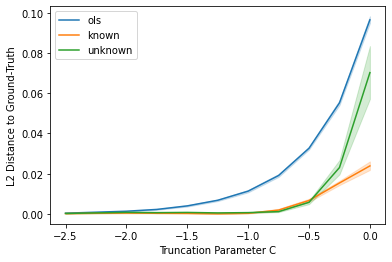

[Text(0.5, 0, 'Truncation Parameter C'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

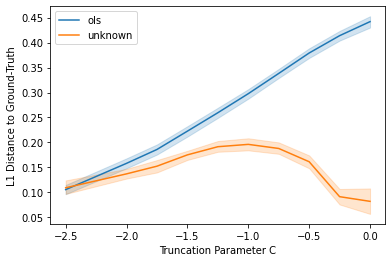

In [204]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols')
ax = sns.lineplot(data=logs, x='c', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='c', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance to Ground-Truth')

In [114]:
trunc_ols = LinearRegression().fit(x_trunc, y_trunc)
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
emp_noise_var

tensor([0.4925])

In [115]:
emp_noise_scale = ch.sqrt(emp_noise_var / 2)
emp_noise_scale

tensor([0.4962])

In [117]:
(emp_noise_var / 2).pow(.5)

tensor([0.4962])

In [120]:
new_noised = noised / ch.sqrt(emp_noise_var)
new_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

In [121]:
ols = LinearRegression().fit(x_trunc_norm, new_y_trunc)

In [122]:
(new_y_trunc - ols.predict(x_trunc_norm)).var(0)

tensor([1.])

In [112]:
another_ols = LinearRegression()
another_ols.fit(X, noised / noise_scale)

LinearRegression()

In [113]:
(noised - another_ols.predict(X)).var(0)

tensor([1.0035])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

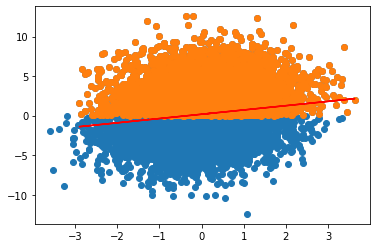

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])